# Comparative Analysis of ONA, CMA, and DEMA Algorithms for Aethalometer Data

## 1. Introduction and Background

This notebook implements and compares three post-processing algorithms for micro-aethalometer data:
  
1. **Optimized Noise-reduction Algorithm (ONA)**: A method described by Hagler et al. (2011) that adaptively time-averages BC data based on incremental light attenuation (ΔATN).

2. **Centered Moving Average (CMA)**: A smoothing technique that incorporates data points both before and after each measurement to reduce noise while preserving microenvironmental characteristics.

3. **Double Exponentially Weighted Moving Average (DEMA)**: A smoothing approach that reduces noise-induced artifacts while limiting lag, especially useful for source apportionment calculations.
 
Both CMA and DEMA have been shown to outperform ONA for newer dual-spot aethalometers in recent research by Liu et al. (2021) and Mendoza et al. (2024).


## 2. Import Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
import numba
from IPython.display import display

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 3. Load and Explore the Data
 
First, let's load the Aethalometer data and examine its structure.

In [2]:
# Define the file path - replace with your actual file path
file_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"  # Replace with your file path

# Check if pyarrow is available for optimal performance
try:
    import pyarrow
    use_pyarrow = True
except ImportError:
    print("Warning: pyarrow not found, using slower pandas conversion method")
    use_pyarrow = False

# Load the data with Polars
pl_data = pl.read_csv(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {pl_data.shape}")
print("\nColumn names:")
print(pl_data.columns)

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(pl_data.head())

# Create a table to collect wavelength statistics
wavelength_stats = []
wavelengths = ['UV', 'Blue', 'Green', 'Red', 'IR']

# Check for the presence of BC columns for each wavelength
for wavelength in wavelengths:
    bc_col = f"{wavelength} BCc"
    atn_col = f"{wavelength} ATN1"
    
    if bc_col in pl_data.columns:
        # Using Polars expressions for statistics
        stats = {}
        stats["Wavelength"] = wavelength
        
        # Get BC range
        bc_range = pl_data.select([
            pl.col(bc_col).min().alias("bc_min"),
            pl.col(bc_col).max().alias("bc_max")
        ])
        stats["BC Min (ng/m³)"] = int(bc_range[0, "bc_min"])
        stats["BC Max (ng/m³)"] = int(bc_range[0, "bc_max"])
        
        # Count negative values
        neg_count = pl_data.filter(pl.col(bc_col) < 0).height
        neg_percentage = (neg_count / pl_data.height) * 100
        stats["Negative BC Count"] = neg_count
        stats["Negative BC (%)"] = round(neg_percentage, 2)
        
        # Get ATN range if available
        if atn_col in pl_data.columns:
            atn_range = pl_data.select([
                pl.col(atn_col).min().alias("atn_min"),
                pl.col(atn_col).max().alias("atn_max")
            ])
            stats["ATN Min"] = float(atn_range[0, "atn_min"])
            stats["ATN Max"] = float(atn_range[0, "atn_max"])
        else:
            stats["ATN Min"] = None
            stats["ATN Max"] = None
        
        wavelength_stats.append(stats)
    else:
        print(f"\nWarning: {wavelength} data columns not found")

# Create a DataFrame from the statistics and explicitly set the data types
if wavelength_stats:
    stats_df = pl.DataFrame(wavelength_stats)
    
    # Ensure proper data types for better display
    stats_df = stats_df.with_columns([
        pl.col("Wavelength").cast(pl.Utf8),
        pl.col("BC Min (ng/m³)").cast(pl.Int64),
        pl.col("BC Max (ng/m³)").cast(pl.Int64),
        pl.col("Negative BC Count").cast(pl.Int64),
        pl.col("Negative BC (%)").cast(pl.Float64).round(2),
        pl.col("ATN Min").cast(pl.Float64).round(3),
        pl.col("ATN Max").cast(pl.Float64).round(3)
    ])
    
    print("\nWavelength Statistics:")
    
    # Convert to pandas for better display formatting
    import pandas as pd
    pd_stats = stats_df.to_pandas()
    
    # Format the display to remove quotes
    pd.set_option('display.precision', 2)
    display(pd_stats)

# Check the time resolution
if 'Timebase (s)' in pl_data.columns:
    timebase = pl_data.select(pl.col('Timebase (s)')).row(0)[0]
    print(f"\nInstrument timebase: {timebase} seconds")
else:
    print("\nTimebase column not found")

# Convert to pandas for compatibility with the rest of the notebook
# Use pyarrow if available for better performance
if use_pyarrow:
    data = pl_data.to_pandas()
else:
    # Fallback method if pyarrow is not available
    import pandas as pd
    data = pd.DataFrame({col: pl_data[col].to_numpy() for col in pl_data.columns})

Dataset shape: (1095086, 77)

Column names:
['Serial number', 'Time (UTC)', 'Datum ID', 'Session ID', 'Data format version', 'Firmware version', 'App version', 'Timezone offset (mins)', 'Date local (yyyy/MM/dd)', 'Time local (hh:mm:ss)', 'GPS lat (ddmm.mmmmm)', 'GPS long (dddmm.mmmmm)', 'GPS speed (km/h)', 'GPS sat count', 'Timebase (s)', 'Status', 'Battery remaining (%)', 'Accel X', 'Accel Y', 'Accel Z', 'Tape position', 'Flow setpoint (mL/min)', 'Flow total (mL/min)', 'Flow1 (mL/min)', 'Flow2 (mL/min)', 'Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 'Internal pressure (Pa)', 'Internal temp (C)', 'Optical config', 'UV Sen1', 'UV Sen2', 'UV Ref', 'UV ATN1', 'UV ATN2', 'UV K', 'Blue Sen1', 'Blue Sen2', 'Blue Ref', 'Blue ATN1', 'Blue ATN2', 'Blue K', 'Green Sen1', 'Green Sen2', 'Green Ref', 'Green ATN1', 'Green ATN2', 'Green K', 'Red Sen1', 'Red Sen2', 'Red Ref', 'Red ATN1', 'Red ATN2', 'Red K', 'IR Sen1', 'IR Sen2', 'IR Ref', 'IR ATN1', 'IR ATN2', 'IR K', 'UV BC1', 'UV BC2',

shape: (5, 77)
┌────────────────┬───────────────┬──────────┬────────────┬───┬────────┬────────┬────────┬──────────┐
│ Serial number  ┆ Time (UTC)    ┆ Datum ID ┆ Session ID ┆ … ┆ IR BC1 ┆ IR BC2 ┆ IR BCc ┆ Readable │
│ ---            ┆ ---           ┆ ---      ┆ ---        ┆   ┆ ---    ┆ ---    ┆ ---    ┆ status   │
│ str            ┆ str           ┆ i64      ┆ i64        ┆   ┆ i64    ┆ i64    ┆ i64    ┆ ---      │
│                ┆               ┆          ┆            ┆   ┆        ┆        ┆        ┆ str      │
╞════════════════╪═══════════════╪══════════╪════════════╪═══╪════════╪════════╪════════╪══════════╡
│ MA350-0238     ┆ 2022-04-12T09 ┆ 26133    ┆ 12         ┆ … ┆ null   ┆ null   ┆ null   ┆ NA       │
│                ┆ :46:01Z       ┆          ┆            ┆   ┆        ┆        ┆        ┆          │
│ MA350-0238     ┆ 2022-04-12T09 ┆ 26134    ┆ 12         ┆ … ┆ 18120  ┆ 16389  ┆ 18120  ┆ NA       │
│                ┆ :47:01Z       ┆          ┆            ┆   ┆        ┆        ┆        ┆          │
│ MA350-0238     ┆ 2022-04-12T09 ┆ 26135    ┆ 12         ┆ … ┆ 10784  ┆ 9686   ┆ 10784  ┆ NA       │
│                ┆ :48:01Z       ┆          ┆            ┆   ┆        ┆        ┆        ┆          │
│ MA350-0238     ┆ 2022-04-12T09 ┆ 26136    ┆ 12         ┆ … ┆ 6263   ┆ 5908   ┆ 6263   ┆ NA       │
│                ┆ :49:01Z       ┆          ┆            ┆   ┆        ┆        ┆        ┆          │
│ MA350-0238     ┆ 2022-04-12T09 ┆ 26137    ┆ 12         ┆ … ┆ 6411   ┆ 6101   ┆ 6411   ┆ NA       │
│                ┆ :50:01Z       ┆          ┆            ┆   ┆        ┆        ┆        ┆          │
└────────────────┴───────────────┴──────────┴────────────┴───┴────────┴────────┴────────┴──────────┘


Wavelength Statistics:


Wavelength  BC Min (ng/m³)  BC Max (ng/m³)  Negative BC Count  \
0         UV         -211848          509219              26701   
1       Blue      -234329472       216328672              18394   
2      Green         -366719          737819              19824   
3        Red         -182273          583168              21969   
4         IR         -149717          547607              30983   

   Negative BC (%)  ATN Min  ATN Max  
0             2.44      0.0   100.43  
1             1.68      0.0    88.14  
2             1.81      0.0    82.06  
3             2.01      0.0    73.40  
4             2.83      0.0    60.40


Instrument timebase: 60 seconds


## 4. ONA Algorithm Implementation
  
The Optimized Noise-reduction Algorithm (ONA) adaptively time-averages BC data based on incremental light attenuation (ΔATN).

In [3]:
@numba.jit(nopython=True)
def _numba_nanmean(arr_slice):
    """
    Numba-compatible nanmean.
    """
    finite_sum = 0.0
    finite_count = 0
    for x in arr_slice:
        if not np.isnan(x): # np.isnan is Numba compatible
            finite_sum += x
            finite_count += 1
    if finite_count == 0:
        return np.nan
    return finite_sum / finite_count

@numba.jit(nopython=True)
def process_ona_segment_numba_core(
    bc_col_np: np.ndarray,
    atn_col_np: np.ndarray,
    delta_atn_min: float,
    num_rows: int
):
    """
    Core ONA algorithm implemented for Numba.
    Operates on NumPy arrays for a single data segment.
    This logic closely mirrors the MATLAB ONA windowing approach within a segment.
    """
    # Initialize output arrays
    smoothed_col_np = bc_col_np.copy() # Start with original BC values
    points_col_np = np.ones(num_rows, dtype=np.int64) # Default points averaged is 1

    # If only one point (or none) in the segment, it's effectively averaged with itself.
    # smoothed_col_np is already a copy, and points_col_np is already 1.
    if num_rows <= 1:
        return smoothed_col_np, points_col_np

    j = 0 # Current starting index of the averaging window (0-based)
    while j < num_rows:
        cur_atn = atn_col_np[j]

        # Find the end of the window (exclusive index).
        # The window includes point j. All subsequent points k in the window
        # must satisfy: atn_col_np[k] <= cur_atn + delta_atn_min
        # and k must be < num_rows (within the current segment).
        window_end_exclusive = j + 1
        while window_end_exclusive < num_rows:
            if atn_col_np[window_end_exclusive] > cur_atn + delta_atn_min:
                break # End of window found
            window_end_exclusive += 1
        
        # The current window for averaging is from index j to window_end_exclusive-1
        slice_bc_np = bc_col_np[j:window_end_exclusive]
        
        avg_bc = _numba_nanmean(slice_bc_np)
        num_points_in_window = window_end_exclusive - j # Length of the slice

        # Apply the averaged BC value and points count to all rows in the window
        for k_idx in range(j, window_end_exclusive):
            smoothed_col_np[k_idx] = avg_bc
            points_col_np[k_idx] = num_points_in_window
            
        # Move to the start of the next potential window
        j = window_end_exclusive
            
    return smoothed_col_np, points_col_np

# Assuming process_ona_segment_numba_core and _numba_nanmean are defined above

def process_ona_segment_numba_wrapper(
    pdf: pd.DataFrame,
    bc_col: str,
    atn_col: str,
    points_col: str,
    smoothed_col: str,
    delta_atn_min: float
) -> pd.DataFrame:
    """
    Wrapper to run the ONA algorithm on one pandas segment using the Numba core.
    Returns the pandas DataFrame with updated points_col and smoothed_col columns.
    """
    # Initialize the columns with default values.
    # Numba core will operate on copies, so these initializations set the base.
    if points_col not in pdf.columns:
        pdf[points_col] = 1
    else:
        pdf.loc[:, points_col] = 1 # Use .loc to avoid SettingWithCopyWarning

    if smoothed_col not in pdf.columns:
        pdf[smoothed_col] = pdf[bc_col].copy()
    else:
        pdf.loc[:, smoothed_col] = pdf[bc_col].copy()


    if len(pdf) <= 1:
        # If the segment is very short, ensure original values (or copy) and 1 point averaged is returned
        # This also ensures the columns exist even if Numba core is skipped.
        pdf.loc[:, smoothed_col] = pdf[bc_col].copy() # Ensure it's a copy of current segment's BC
        pdf.loc[:, points_col] = 1
        return pdf

    # Convert relevant pandas Series to NumPy arrays for Numba
    # Ensure correct dtype. float64 is generally safe for numerical stability.
    bc_col_np = pdf[bc_col].to_numpy(dtype=np.float64, na_value=np.nan)
    atn_col_np = pdf[atn_col].to_numpy(dtype=np.float64, na_value=np.nan)
    
    num_rows = len(pdf)

    # Call the Numba-optimized core function
    smoothed_result_np, points_result_np = process_ona_segment_numba_core(
        bc_col_np, atn_col_np, delta_atn_min, num_rows
    )

    # Assign results back to the pandas DataFrame using .loc to ensure modification
    pdf.loc[:, smoothed_col] = smoothed_result_np
    pdf.loc[:, points_col] = points_result_np
    
    return pdf

# Assuming process_ona_segment_numba_wrapper is defined above

def apply_ona_polars_numba(
    data: pl.DataFrame,
    wavelength: str = "Blue",
    delta_atn_min: float = 0.05
) -> pl.DataFrame:
    """
    Apply the Optimized Noise-reduction Algorithm using Polars for segmentation
    and a Numba-accelerated Pandas UDF for the core ONA processing.
    Includes schema overrides for consistent concatenation.
    """
    # Column names
    bc_col = f"{wavelength} BCc"
    atn_col = f"{wavelength} ATN1"
    points_col = f"{wavelength}_points_averaged"
    smoothed_col = f"{wavelength}_BC_ONA"

    # --- Boilerplate: Check if required columns exist ---
    if atn_col not in data.columns or bc_col not in data.columns:
        print(f"Warning: Required columns ({atn_col}, {bc_col}) not found for ONA on wavelength {wavelength}. Skipping ONA.")
        output_data = data.clone()
        if points_col not in output_data.columns:
            output_data = output_data.with_columns(pl.lit(1).cast(pl.Int64).alias(points_col))
        if smoothed_col not in output_data.columns:
            if bc_col in output_data.columns: # Check if bc_col exists before trying to alias from it
                output_data = output_data.with_columns(pl.col(bc_col).alias(smoothed_col))
            else: # If bc_col also doesn't exist, fill with nulls
                output_data = output_data.with_columns(pl.lit(None, dtype=pl.Float64).alias(smoothed_col))
        return output_data

    # --- Segmentation Logic (using Polars) ---
    # This part is different from MATLAB's manual `filtchange` array construction,
    # but it's a robust way to define segments for processing.
    df = data.clone()
    df = df.with_columns(
        pl.col(atn_col).diff().abs().alias("ΔATN") # First value will be null
    )
    # A new segment starts if ΔATN > 30 OR if ΔATN is null (which handles the very first row)
    df = df.with_columns(
        (
            (pl.col("ΔATN") > 30) | pl.col("ΔATN").is_null()
        )
        .fill_null(True) # Ensure the is_null() condition on the first row creates a segment
        .cast(pl.Int32)
        .cum_sum() # Create a unique ID for each segment
        .alias("segment_id")
    )
    actual_filter_changes = df.filter(pl.col("ΔATN") > 30).height # Count actual breaks
    print(f"Number of actual filter changes (ΔATN > 30) detected for {wavelength}: {actual_filter_changes}")
    
    # Initialize output columns in the main DataFrame before splitting into segments
    # The values will be correctly populated by the wrapper.
    df = df.with_columns([
        pl.lit(1).cast(pl.Int64).alias(points_col),
        pl.col(bc_col).cast(pl.Float64).alias(smoothed_col) 
    ])
    
    # Determine sort column for ensuring data order
    if "Time (UTC)" in df.columns:
        sort_col = "Time (UTC)"
    elif "_idx" in df.columns: # If an _idx column was previously added
        sort_col = "_idx"
    else: # Add a row count if no other suitable sort column exists
        df = df.with_row_count("_idx")
        sort_col = "_idx"

    # --- Process Each Segment ---
    processed_segments_list = []
    # Group by segment_id and apply the processing.
    # Using group_by().apply() can be more idiomatic in Polars/Pandas if the UDF is adapted.
    # However, explicit loop is fine and perhaps clearer for this translation.
    unique_segment_ids = df.get_column("segment_id").unique().sort()


    for seg_id_val in unique_segment_ids:
        segment_pl = df.filter(pl.col("segment_id") == seg_id_val)
        segment_pl = segment_pl.sort(sort_col) # Ensure order within segment
        
        # Convert segment to Pandas DataFrame for the Numba wrapper
        pd_segment = segment_pl.to_pandas()
        
        pd_processed_segment = process_ona_segment_numba_wrapper(
            pd_segment, bc_col, atn_col, points_col, smoothed_col, delta_atn_min
        )

        # Define schema overrides for consistency when converting back to Polars
        # This is important because operations in Pandas can sometimes alter dtypes.
        schema_overrides_dict = {
            points_col: pl.Int64,    
            smoothed_col: pl.Float64 
        }
        
        # Ensure any other columns that might be affected maintain their type (example below)
        problematic_bc_pass_through_cols = [
            'UV BC1', 'UV BC2', 'UV BCc', 'Blue BC1', 'Blue BC2', # 'Blue BCc' is bc_col
            'Green BC1', 'Green BC2', 'Green BCc', 'Red BC1', 'Red BC2', 'Red BCc',
            'IR BC1', 'IR BC2', 'IR BCc'
        ]
        for col_to_override in problematic_bc_pass_through_cols:
            if col_to_override in pd_processed_segment.columns and col_to_override != bc_col : # bc_col is already handled by smoothed_col if they are same initially
                 if col_to_override != smoothed_col: # smoothed_col already in schema_overrides_dict
                    schema_overrides_dict[col_to_override] = pl.Float64

        pl_processed_segment = pl.from_pandas(
            pd_processed_segment,
            schema_overrides=schema_overrides_dict
        )
        processed_segments_list.append(pl_processed_segment)

    # --- Combine Processed Segments ---
    if processed_segments_list:
        try:
            result_df = pl.concat(processed_segments_list, how="vertical_relaxed") # Use vertical_relaxed for more robustness
        except pl.SchemaError as e: # Should be less likely with vertical_relaxed and schema_overrides
            print(f"Polars concat failed even with vertical_relaxed: {e}")
            raise 

        result_df = result_df.sort(sort_col) # Restore original overall order
        
        # Drop temporary columns
        temp_cols_to_drop = ["ΔATN", "segment_id"]
        if sort_col == "_idx" and "_idx" not in data.columns : # If _idx was added by this function
            temp_cols_to_drop.append("_idx")
        
        final_cols_to_drop = [col for col in temp_cols_to_drop if col in result_df.columns]
        if final_cols_to_drop:
            result_df = result_df.drop(final_cols_to_drop)
    else: # Should not happen if df has rows
        result_df = df.clone() # Start from a clone of the (potentially _idx added) df
        temp_cols_to_drop = ["ΔATN", "segment_id"]
        if sort_col == "_idx" and "_idx" not in data.columns:
             temp_cols_to_drop.append("_idx")
        final_cols_to_drop = [col for col in temp_cols_to_drop if col in result_df.columns]
        if final_cols_to_drop:
            result_df = result_df.drop(final_cols_to_drop)


    return result_df

## 5. CMA Algorithm Implementation
  
The Centered Moving Average is a smoothing technique that uses data points both before and after each measurement.

In [4]:
def apply_cma_polars(data, wavelength='Blue', window_size=None):
    """
    Apply the Centered Moving Average algorithm to Aethalometer data (Polars implementation)
    
    Parameters:
    -----------
    data : polars.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    window_size : int or None
        Size of the moving average window (must be odd). If None, 
        will use a default based on the data's timebase
        
    Returns:
    --------
    data_smoothed : polars.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.clone()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BCc"
    smoothed_bc_col = f"{wavelength}_BC_CMA"
    
    # Determine window size if not specified
    if window_size is None:
        if 'Timebase (s)' in data_smoothed.columns:
            timebase = data_smoothed.select(pl.col('Timebase (s)')).row(0)[0]
            if timebase == 1:
                window_size = 11  # 11 seconds for 1-second data
            elif timebase == 5:
                window_size = 5   # 25 seconds for 5-second data
            elif timebase == 60:
                window_size = 3   # 3 minutes for 1-minute data
            else:
                window_size = 5   # Default for other timebases
        else:
            window_size = 5       # Default if timebase is unknown
    
    # Make sure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    print(f"Using window size of {window_size} for CMA on {wavelength}")
    
    # Apply rolling mean with center=True
    data_smoothed = data_smoothed.with_columns(
        pl.col(bc_col).rolling_mean(
            window_size=window_size,
            center=True,
            min_samples=1  # Updated from min_periods to min_samples
        ).alias(smoothed_bc_col)
    )
    
    return data_smoothed

## 6. DEMA Algorithm Implementation
 
The Double Exponentially Weighted Moving Average applies additional smoothing to an EMA to reduce noise while limiting lag.

In [5]:
def apply_dema_polars(data, wavelength='Blue', alpha=None):
    """
    Apply the Double Exponentially Weighted Moving Average algorithm (Polars implementation)
    
    Parameters:
    -----------
    data : polars.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    alpha : float
        Smoothing parameter (between 0 and 1)
        For 60s data, 0.125 approximates a 15-minute smoothing window
        
    Returns:
    --------
    data_smoothed : polars.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.clone()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BCc"
    ema_col = f"{wavelength}_EMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Set the smoothing parameter based on timebase if not explicitly provided
    if 'Timebase (s)' in data_smoothed.columns:
        timebase = data_smoothed.select(pl.col('Timebase (s)')).row(0)[0]
        if alpha is None:
            # Use formula 2/(N+1) where N is the desired smoothing period
            if timebase == 1:
                # Default to approximate 5-minute window for 1-second data
                N = 300 / timebase
            elif timebase == 5:
                # Default to approximate 5-minute window for 5-second data
                N = 300 / timebase
            elif timebase == 60:
                # Default to approximate 15-minute window for 60-second data
                N = 900 / timebase
            else:
                N = 15  # Default for other timebases
                
            alpha = 2 / (N + 1)
    else:
        # Default alpha if timebase is unknown
        if alpha is None:
            alpha = 0.125
    
    print(f"Using alpha of {alpha:.4f} for DEMA on {wavelength}")
    
    # First EMA calculation
    data_smoothed = data_smoothed.with_columns(
        pl.col(bc_col).ewm_mean(alpha=alpha, adjust=False).alias(ema_col)
    )
    
    # Second EMA calculation (EMA of EMA)
    data_smoothed = data_smoothed.with_columns(
        pl.col(ema_col).ewm_mean(alpha=alpha, adjust=False).alias("ema_of_ema")
    )
    
    # Calculate DEMA: (2 * EMA) - EMA(EMA)
    data_smoothed = data_smoothed.with_columns(
        (2 * pl.col(ema_col) - pl.col("ema_of_ema")).alias(dema_col)
    )
    
    # Drop the temporary ema_of_ema column
    data_smoothed = data_smoothed.drop("ema_of_ema")
    
    return data_smoothed

## 7. Apply All Processing Methods to Data

In [6]:
# Create separate dataframes for each method using Polars
pl_processed_data_raw = pl_data.clone()
pl_processed_data_ona = pl_data.clone()
pl_processed_data_cma = pl_data.clone()
pl_processed_data_dema = pl_data.clone()

# Set the minimum change in attenuation (ΔATN) for ONA
delta_atn_min = 0.05  # Default value from the Hagler paper

# Process each wavelength with all methods
for wavelength in wavelengths:
    bc_col = f"{wavelength} BCc"
    atn_col = f"{wavelength} ATN1"
    
    if bc_col in pl_processed_data_raw.columns: # Check if the primary data column exists
        # Apply ONA if ATN column also exists (required for ONA)
        if atn_col in pl_processed_data_raw.columns: # Ensure ATN column exists in the source data
            print(f"\nApplying ONA to {wavelength} wavelength data...")
            # VVV This is the updated line VVV
            pl_processed_data_ona = apply_ona_polars_numba(pl_processed_data_ona, wavelength, delta_atn_min)
        else:
            print(f"\nSkipping ONA for {wavelength}: ATN column ({atn_col}) not found.")
        
        # Apply CMA
        print(f"\nApplying CMA to {wavelength} wavelength data...")
        pl_processed_data_cma = apply_cma_polars(pl_processed_data_cma, wavelength) # Assuming this function is defined
        
        # Apply DEMA
        print(f"\nApplying DEMA to {wavelength} wavelength data...")
        pl_processed_data_dema = apply_dema_polars(pl_processed_data_dema, wavelength) # Assuming this function is defined

# Convert to pandas for compatibility with downstream functions if needed
processed_data_raw = pl_processed_data_raw.to_pandas()
processed_data_ona = pl_processed_data_ona.to_pandas()
processed_data_cma = pl_processed_data_cma.to_pandas()
processed_data_dema = pl_processed_data_dema.to_pandas()


Applying ONA to UV wavelength data...
Number of actual filter changes (ΔATN > 30) detected for UV: 814

Applying CMA to UV wavelength data...
Using window size of 3 for CMA on UV

Applying DEMA to UV wavelength data...
Using alpha of 0.1250 for DEMA on UV

Applying ONA to Blue wavelength data...
Number of actual filter changes (ΔATN > 30) detected for Blue: 813

Applying CMA to Blue wavelength data...
Using window size of 3 for CMA on Blue

Applying DEMA to Blue wavelength data...
Using alpha of 0.1250 for DEMA on Blue

Applying ONA to Green wavelength data...
Number of actual filter changes (ΔATN > 30) detected for Green: 812

Applying CMA to Green wavelength data...
Using window size of 3 for CMA on Green

Applying DEMA to Green wavelength data...
Using alpha of 0.1250 for DEMA on Green

Applying ONA to Red wavelength data...
Number of actual filter changes (ΔATN > 30) detected for Red: 811

Applying CMA to Red wavelength data...
Using window size of 3 for CMA on Red

Applying DEMA 

## 8. Calculate Source Apportionment
 
Following the recommendations from recent research, we'll implement source apportionment calculations using the Aethalometer model for each processing method.

In [7]:
def calculate_source_apportionment(data, aae_wb=2.0, aae_ff=1.0):
    """
    Calculate source apportionment using the Aethalometer Model
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with BC data at blue and IR wavelengths
    aae_wb : float
        Absorption Ångström Exponent for wood burning (default 2.0)
    aae_ff : float
        Absorption Ångström Exponent for fossil fuel (default 1.0)
    
    Returns:
    --------
    data_sa : pandas.DataFrame
        DataFrame with additional source apportionment columns
    """
    # Create a copy of the input dataframe
    data_sa = data.copy()
    
    # Convert to Polars for faster calculations
    pl_data = pl.from_pandas(data[['Blue BCc', 'IR BCc']])
    
    # Constants
    mac_blue = 10.12  # m²/g at 470nm
    mac_ir = 7.77     # m²/g at 880nm
    c_ref = 1.3       # Multiple scattering enhancement factor
    wavelength_ratio = 470 / 880
    
    # Calculate absorption coefficients
    pl_data = pl_data.with_columns(
        (pl.col('Blue BCc') * mac_blue / c_ref).alias('Babs_Blue'),
        (pl.col('IR BCc') * mac_ir / c_ref).alias('Babs_IR')
    )
    
    # Calculate absorption coefficients for wood burning and fossil fuel at IR wavelength
    pl_data = pl_data.with_columns(
        ((pl.col('Babs_Blue') - pl.col('Babs_IR') * (wavelength_ratio ** (-aae_wb))) / 
        ((wavelength_ratio ** (-aae_ff)) - (wavelength_ratio ** (-aae_wb)))).alias('Babs_FF_IR')
    )
    
    pl_data = pl_data.with_columns(
        (pl.col('Babs_IR') - pl.col('Babs_FF_IR')).alias('Babs_WB_IR')
    )
    
    # Calculate BB% (biomass burning percentage)
    pl_data = pl_data.with_columns(
        (100 * pl.col('Babs_WB_IR') / pl.col('Babs_IR')).alias('BB_Percent')
    )
    
    # Handle infinity and NaN values
    pl_data = pl_data.with_columns(
        pl.when(pl.col('BB_Percent').is_infinite() | pl.col('BB_Percent').is_nan())
        .then(pl.lit(0))
        .otherwise(pl.col('BB_Percent'))
        .alias('BB_Percent')
    )
    
    # Calculate BC from wood burning and fossil fuel
    pl_data = pl_data.with_columns(
        (pl.col('IR BCc') * pl.col('BB_Percent') / 100).alias('BC_WB'),
        (pl.col('IR BCc') * (100 - pl.col('BB_Percent')) / 100).alias('BC_FF')
    )
    
    # Convert back to pandas DataFrame
    for col in pl_data.columns:
        if col not in data_sa.columns:
            data_sa[col] = pl_data[col].to_numpy()
    
    return data_sa

In [8]:
# Calculate source apportionment for raw data
print("\nCalculating source apportionment for raw data...")
processed_data_raw_sa = calculate_source_apportionment(processed_data_raw)

# Calculate source apportionment for ONA-processed data
if 'Blue_BC_ONA' in processed_data_ona.columns and 'IR_BC_ONA' in processed_data_ona.columns:
    print("\nCalculating source apportionment for ONA-processed data...")
    processed_data_ona_sa = processed_data_ona.copy()
    # Use the ONA-processed data for source apportionment
    processed_data_ona_sa['Blue BCc'] = processed_data_ona['Blue_BC_ONA']
    processed_data_ona_sa['IR BCc'] = processed_data_ona['IR_BC_ONA']
    processed_data_ona_sa = calculate_source_apportionment(processed_data_ona_sa)
else:
    processed_data_ona_sa = processed_data_raw_sa.copy()
    print("\nWarning: ONA-processed data not available for both Blue and IR wavelengths, using raw data for source apportionment")

# Calculate source apportionment for CMA-processed data
print("\nCalculating source apportionment for CMA-processed data...")
processed_data_cma_sa = processed_data_cma.copy()
# Use the CMA-processed data for source apportionment
processed_data_cma_sa['Blue BCc'] = processed_data_cma['Blue_BC_CMA']
processed_data_cma_sa['IR BCc'] = processed_data_cma['IR_BC_CMA']
processed_data_cma_sa = calculate_source_apportionment(processed_data_cma_sa)

# Calculate source apportionment for DEMA-processed data
print("\nCalculating source apportionment for DEMA-processed data...")
processed_data_dema_sa = processed_data_dema.copy()
# Use the DEMA-processed data for source apportionment
processed_data_dema_sa['Blue BCc'] = processed_data_dema['Blue_BC_DEMA']
processed_data_dema_sa['IR BCc'] = processed_data_dema['IR_BC_DEMA'] 
processed_data_dema_sa = calculate_source_apportionment(processed_data_dema_sa)


Calculating source apportionment for raw data...

Calculating source apportionment for ONA-processed data...

Calculating source apportionment for CMA-processed data...

Calculating source apportionment for DEMA-processed data...


## 9. Evaluate Processing Performance
  
Now let's evaluate how well each processing method performed and compare them.

In [9]:
def evaluate_processing(data_raw, data_processed, raw_col, processed_col):
    """
    Evaluate the performance of a processing algorithm
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with original data
    data_processed : pandas.DataFrame
        DataFrame with processed data
    raw_col : str
        Column name for raw data
    processed_col : str
        Column name for processed data
        
    Returns:
    --------
    metrics : dict
        Dictionary of performance metrics
    """
    # Convert to Polars for faster calculations
    pl_raw = pl.from_pandas(data_raw[[raw_col]])
    pl_processed = pl.from_pandas(data_processed[[processed_col]])
    
    # 1. Reduction of negatives
    numneg_raw = pl_raw.filter(pl.col(raw_col) < 0).height / pl_raw.height
    numneg_processed = pl_processed.filter(pl.col(processed_col) < 0).height / pl_processed.height
    
    print(f"Fraction of negative values in raw data: {numneg_raw:.4f}")
    print(f"Fraction of negative values after processing: {numneg_processed:.4f}")
    
    if numneg_raw > 0:
        reduction = (numneg_raw - numneg_processed)/numneg_raw
        print(f"Reduction in negative values: {reduction:.4f} ({reduction*100:.1f}%)")
    else:
        reduction = 0
        print("No negative values in raw data to reduce")
    
    # 2. Reduction of noise (average absolute difference between consecutive points)
    # This is a bit complex with Polars, let's use Pandas/NumPy for this part
    temp_raw = np.abs(np.diff(data_raw[raw_col].values))
    temp_processed = np.abs(np.diff(data_processed[processed_col].values))
    
    noise_raw = np.nanmean(temp_raw)
    noise_processed = np.nanmean(temp_processed)
    
    print(f"Noise in raw data: {noise_raw:.1f} ng/m³")
    print(f"Noise in processed data: {noise_processed:.1f} ng/m³")
    print(f"Noise reduction factor: {noise_raw/noise_processed:.1f}x")
    
    # 3. Calculate correlation with raw data
    # Create a combined Polars DataFrame
    pl_combined = pl.from_pandas(pd.DataFrame({
        'raw': data_raw[raw_col],
        'processed': data_processed[processed_col]
    }))
    
    correlation = pl_combined.select(
        pl.corr('raw', 'processed').alias('correlation')
    )[0, 0]
    
    print(f"Correlation with raw data: {correlation:.4f}")
    
    return {
        'negative_original': numneg_raw,
        'negative_processed': numneg_processed,
        'negative_reduction': reduction,
        'noise_original': noise_raw,
        'noise_processed': noise_processed,
        'noise_reduction': noise_raw/noise_processed,
        'correlation': correlation
    }

In [42]:
# Place this after Section 8 or at the start of Section 9

print("\nCalculating Source Apportionment Stability Metrics (Std Dev of BB%)...")
sa_stability_metrics = {} # Initialize the dictionary

# Raw data
if 'processed_data_raw_sa' in locals() and 'BB_Percent' in processed_data_raw_sa.columns:
    sa_stability_metrics['Raw'] = processed_data_raw_sa['BB_Percent'].std()
else:
    sa_stability_metrics['Raw'] = np.nan
    print("Warning: Raw SA data for BB% std dev not found.")

# ONA processed data
if 'processed_data_ona_sa' in locals() and 'BB_Percent' in processed_data_ona_sa.columns:
    sa_stability_metrics['ONA'] = processed_data_ona_sa['BB_Percent'].std()
else:
    sa_stability_metrics['ONA'] = np.nan
    print("Warning: ONA SA data for BB% std dev not found.")

# CMA processed data
if 'processed_data_cma_sa' in locals() and 'BB_Percent' in processed_data_cma_sa.columns:
    sa_stability_metrics['CMA'] = processed_data_cma_sa['BB_Percent'].std()
else:
    sa_stability_metrics['CMA'] = np.nan
    print("Warning: CMA SA data for BB% std dev not found.")
    
# DEMA processed data
if 'processed_data_dema_sa' in locals() and 'BB_Percent' in processed_data_dema_sa.columns:
    sa_stability_metrics['DEMA'] = processed_data_dema_sa['BB_Percent'].std()
else:
    sa_stability_metrics['DEMA'] = np.nan
    print("Warning: DEMA SA data for BB% std dev not found.")

print("\nSource Apportionment Stability Metrics (Std Dev of BB%):")
for method, std_dev in sa_stability_metrics.items():
    if not np.isnan(std_dev):
        print(f"  {method}: {std_dev:.2f}")
    else:
        print(f"  {method}: N/A")
        
# Evaluate each wavelength and method
summary_metrics = {}

for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    if bc_col in data.columns:
        print(f"\n===== Performance Evaluation for {wavelength} Wavelength =====")
        
        # Evaluate ONA if available
        if ona_col in processed_data_ona.columns:
            print(f"\nEvaluating ONA for {wavelength} wavelength:")
            summary_metrics[f"{wavelength}_ONA"] = evaluate_processing(data, processed_data_ona, bc_col, ona_col)
        
        # Evaluate CMA
        print(f"\nEvaluating CMA for {wavelength} wavelength:")
        summary_metrics[f"{wavelength}_CMA"] = evaluate_processing(data, processed_data_cma, bc_col, cma_col)
        
        # Evaluate DEMA
        print(f"\nEvaluating DEMA for {wavelength} wavelength:")
        summary_metrics[f"{wavelength}_DEMA"] = evaluate_processing(data, processed_data_dema, bc_col, dema_col)

# Create a summary table
summary_table = pd.DataFrame.from_dict(summary_metrics, orient='index')
summary_table.columns = [
    'Negative values (original)',
    'Negative values (processed)', 
    'Negative reduction',
    'Noise (original ng/m³)', 
    'Noise (processed ng/m³)',
    'Noise reduction factor',
    'Correlation with raw'
]

# Display the summary table
print("\n===== Summary of Method Performance =====")
display(summary_table)

# Compare Source Apportionment Results
print("\n===== Source Apportionment Comparison =====")
print("\nComparison of BB% from Raw, ONA, CMA and DEMA processing:")
print(f"Raw data - Mean BB%: {processed_data_raw_sa['BB_Percent'].mean():.2f}, Std: {processed_data_raw_sa['BB_Percent'].std():.2f}")

if 'BB_Percent' in processed_data_ona_sa.columns:
    print(f"ONA data - Mean BB%: {processed_data_ona_sa['BB_Percent'].mean():.2f}, Std: {processed_data_ona_sa['BB_Percent'].std():.2f}")

print(f"CMA data - Mean BB%: {processed_data_cma_sa['BB_Percent'].mean():.2f}, Std: {processed_data_cma_sa['BB_Percent'].std():.2f}")
print(f"DEMA data - Mean BB%: {processed_data_dema_sa['BB_Percent'].mean():.2f}, Std: {processed_data_dema_sa['BB_Percent'].std():.2f}")


Calculating Source Apportionment Stability Metrics (Std Dev of BB%)...

Source Apportionment Stability Metrics (Std Dev of BB%):
  Raw: 3375.76
  ONA: 6697.10
  CMA: 1912.86
  DEMA: 1113.76

===== Performance Evaluation for Blue Wavelength =====

Evaluating ONA for Blue wavelength:
Fraction of negative values in raw data: 0.0168
Fraction of negative values after processing: 0.0017
Reduction in negative values: 0.8980 (89.8%)
Noise in raw data: 4008.2 ng/m³
Noise in processed data: 2436.3 ng/m³
Noise reduction factor: 1.6x
Correlation with raw data: 0.8417

Evaluating CMA for Blue wavelength:
Fraction of negative values in raw data: 0.0168
Fraction of negative values after processing: 0.0029
Reduction in negative values: 0.8301 (83.0%)
Noise in raw data: 4008.2 ng/m³
Noise in processed data: 1506.8 ng/m³
Noise reduction factor: 2.7x
Correlation with raw data: 0.0612

Evaluating DEMA for Blue wavelength:
Fraction of negative values in raw data: 0.0168
Fraction of negative values after p

Negative values (original)  Negative values (processed)  \
Blue_ONA                         0.02                     1.71e-03   
Blue_CMA                         0.02                     2.85e-03   
Blue_DEMA                        0.02                     1.42e-03   
IR_ONA                           0.03                     2.21e-03   
IR_CMA                           0.03                     5.05e-03   
IR_DEMA                          0.03                     2.12e-03   

           Negative reduction  Noise (original ng/m³)  \
Blue_ONA                 0.90                 4008.16   
Blue_CMA                 0.83                 4008.16   
Blue_DEMA                0.92                 4008.16   
IR_ONA                   0.92                 2822.54   
IR_CMA                   0.82                 2822.54   
IR_DEMA                  0.92                 2822.54   

           Noise (processed ng/m³)  Noise reduction factor  \
Blue_ONA                   2436.28                    1.65   
Blue_CMA                   1506.84                    2.66   
Blue_DEMA                   791.32                    5.07   
IR_ONA                     1378.38                    2.05   
IR_CMA                     1057.81                    2.67   
IR_DEMA                     578.18                    4.88   

           Correlation with raw  
Blue_ONA                   0.84  
Blue_CMA                   0.06  
Blue_DEMA                  0.69  
IR_ONA                     0.98  
IR_CMA                     0.95  
IR_DEMA                    0.93


===== Source Apportionment Comparison =====

Comparison of BB% from Raw, ONA, CMA and DEMA processing:
Raw data - Mean BB%: -26.47, Std: 3375.76
ONA data - Mean BB%: -22.76, Std: 6697.10
CMA data - Mean BB%: -28.72, Std: 1912.86
DEMA data - Mean BB%: -29.44, Std: 1113.76


## 10. Visualize Results
  
Let's visualize the raw and processed data to see the effects of our algorithms.

In [11]:
def plot_comparison(data, data_ona, data_cma, data_dema, wavelength, sample_period=None):
    """
    Plot the raw, ONA, CMA, and DEMA processed BC data for comparison
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to plot
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Check which methods are available
    methods_available = []
    if bc_col in data.columns:
        methods_available.append(('Raw', data, bc_col, 'k-'))
    if ona_col in data_ona.columns:
        methods_available.append(('ONA', data_ona, ona_col, 'b-'))
    if cma_col in data_cma.columns:
        methods_available.append(('CMA', data_cma, cma_col, 'r-'))
    if dema_col in data_dema.columns:
        methods_available.append(('DEMA', data_dema, dema_col, 'g-'))
    
    # If no methods are available, return early
    if not methods_available:
        print(f"No data available for {wavelength} wavelength comparison")
        return
    
    # Use Polars for the data selection and transformation
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_datas = []
        
        for name, df, col, style in methods_available:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_datas.append((name, pl_slice.to_pandas(), col, style))
    else:
        plot_datas = methods_available
    
    # Create a figure
    plt.figure(figsize=(12, 6))
    
    # Create x-axis values - use first dataset for reference
    if len(plot_datas) > 0 and 'Time (UTC)' in plot_datas[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_datas[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            plt.gca().xaxis.set_major_formatter(x_formatter)
            plt.gcf().autofmt_xdate()
            x_label = 'Time (UTC)'
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_datas[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_datas[0][1]) if len(plot_datas) > 0 else 0)
        x_label = 'Data Point'
    
    # Plot BC data for each method
    for name, df, col, style in plot_datas:
        if name == 'Raw':
            plt.plot(x, df[col], style, alpha=0.5, label=name)
        else:
            plt.plot(x, df[col], style, label=name)
    
    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel(f'{wavelength} BC (ng/m³)')
    plt.title(f'Comparison of Noise Reduction Methods for {wavelength} Wavelength')
    
    # Add legend and grid
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Improve layout
    plt.tight_layout()
    
    # Get y-limits based on data to ensure consistent scaling
    if len(plot_datas) > 0:
        all_values = []
        for _, df, col, _ in plot_datas:
            all_values.extend(df[col].dropna().tolist())
        
        if all_values:
            # Use percentiles to avoid extreme outliers
            ymin = np.percentile(all_values, 1)  # 1st percentile
            ymax = np.percentile(all_values, 99)  # 99th percentile
            
            # Add a small buffer
            y_range = ymax - ymin
            plt.ylim([ymin - 0.05 * y_range, ymax + 0.05 * y_range])
    
    # Show the plot
    plt.show()
    
    # Optional: Calculate and display statistics for each method
    if len(plot_datas) > 0:
        # Use Polars for efficient stats calculation
        stats_data = []
        for name, df, col, _ in plot_datas:
            pl_df = pl.from_pandas(df[[col]])
            stats = pl_df.select([
                pl.lit(name).alias("Method"),
                pl.col(col).mean().alias("Mean"),
                pl.col(col).median().alias("Median"),
                pl.col(col).min().alias("Min"),
                pl.col(col).max().alias("Max"),
                pl.col(col).std().alias("Std Dev")
            ])
            stats_data.append(stats)
        
        if stats_data:
            # Combine all stats
            combined_stats = pl.concat(stats_data)
            
            # Display the statistics
            print(f"\nStatistics for {wavelength} wavelength:")
            display(combined_stats)

In [12]:
def plot_source_apportionment_comparison(data_raw, data_ona, data_cma, data_dema, sample_period=None):
    """
    Plot the source apportionment results for raw, ONA, CMA and DEMA data
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Check which methods have source apportionment data
    methods_available = []
    if 'BB_Percent' in data_raw.columns:
        methods_available.append(('Raw', data_raw, 'BB_Percent', 'k-'))
    if 'BB_Percent' in data_ona.columns:
        methods_available.append(('ONA', data_ona, 'BB_Percent', 'b-'))
    if 'BB_Percent' in data_cma.columns:
        methods_available.append(('CMA', data_cma, 'BB_Percent', 'r-'))
    if 'BB_Percent' in data_dema.columns:
        methods_available.append(('DEMA', data_dema, 'BB_Percent', 'g-'))
    
    # If no methods available, return early
    if not methods_available:
        print("No source apportionment data available for comparison")
        return
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_datas = []
        
        for name, df, col, style in methods_available:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_datas.append((name, pl_slice.to_pandas(), col, style))
    else:
        plot_datas = methods_available
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # Create x-axis values - use first dataset for reference
    if len(plot_datas) > 0 and 'Time (UTC)' in plot_datas[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_datas[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_datas[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_datas[0][1]) if len(plot_datas) > 0 else 0)
        x_label = 'Data Point'
    
    # Get y-limits for biomass burning percentage
    bb_values = []
    for name, df, col, _ in plot_datas:
        bb_values.extend(df[col].dropna().tolist())
    
    if bb_values:
        # Use percentiles to avoid extreme outliers but ensure range is within 0-100%
        bb_min = max(0, np.percentile(bb_values, 1))  # 1st percentile
        bb_max = min(100, np.percentile(bb_values, 99))  # 99th percentile
        
        # Add a small buffer
        bb_range = bb_max - bb_min
        bb_ylim = [max(0, bb_min - 0.05 * bb_range), min(100, bb_max + 0.05 * bb_range)]
        
        # Set y-limits for BB percentage plot
        axes[0].set_ylim(bb_ylim)
    
    # Plot BB percentage for each method
    for name, df, col, style in plot_datas:
        if name == 'Raw':
            axes[0].plot(x, df[col], style, alpha=0.5, label=name)
        else:
            axes[0].plot(x, df[col], style, label=name)
    
    axes[0].set_ylabel('Biomass Burning %')
    axes[0].set_title('Source Apportionment Results Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Get wood burning BC values for y-limits
    wb_values = []
    for name, df, _, _ in plot_datas:
        if 'BC_WB' in df.columns:
            wb_values.extend(df['BC_WB'].dropna().tolist())
    
    if wb_values:
        # Set y-limits for wood burning BC plot
        wb_min = np.percentile(wb_values, 1)  # 1st percentile
        wb_max = np.percentile(wb_values, 99)  # 99th percentile
        
        # Add a small buffer
        wb_range = wb_max - wb_min
        axes[1].set_ylim([max(0, wb_min - 0.05 * wb_range), wb_max + 0.05 * wb_range])
    
    # Plot Wood Burning BC for each method
    for name, df, _, style in plot_datas:
        if 'BC_WB' in df.columns:
            if name == 'Raw':
                axes[1].plot(x, df['BC_WB'], style, alpha=0.5, label=name)
            else:
                axes[1].plot(x, df['BC_WB'], style, label=name)
    
    axes[1].set_ylabel('Wood Burning BC (ng/m³)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Get fossil fuel BC values for y-limits
    ff_values = []
    for name, df, _, _ in plot_datas:
        if 'BC_FF' in df.columns:
            ff_values.extend(df['BC_FF'].dropna().tolist())
    
    if ff_values:
        # Set y-limits for fossil fuel BC plot
        ff_min = np.percentile(ff_values, 1)  # 1st percentile
        ff_max = np.percentile(ff_values, 99)  # 99th percentile
        
        # Add a small buffer
        ff_range = ff_max - ff_min
        axes[2].set_ylim([max(0, ff_min - 0.05 * ff_range), ff_max + 0.05 * ff_range])
    
    # Plot Fossil Fuel BC for each method
    for name, df, _, style in plot_datas:
        if 'BC_FF' in df.columns:
            if name == 'Raw':
                axes[2].plot(x, df['BC_FF'], style, alpha=0.5, label=name)
            else:
                axes[2].plot(x, df['BC_FF'], style, label=name)
    
    axes[2].set_ylabel('Fossil Fuel BC (ng/m³)')
    axes[2].set_xlabel(x_label)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Optional: Calculate and display statistics for each source apportionment component
    if len(plot_datas) > 0:
        # Use Polars for efficient stats calculation
        components = ['BB_Percent', 'BC_WB', 'BC_FF']
        stats_data = []
        
        for name, df, _, _ in plot_datas:
            for component in components:
                if component in df.columns:
                    pl_df = pl.from_pandas(df[[component]])
                    stats = pl_df.select([
                        pl.lit(name).alias("Method"),
                        pl.lit(component).alias("Component"),
                        pl.col(component).mean().alias("Mean"),
                        pl.col(component).median().alias("Median"),
                        pl.col(component).min().alias("Min"),
                        pl.col(component).max().alias("Max"),
                        pl.col(component).std().alias("Std Dev")
                    ])
                    stats_data.append(stats)
        
        if stats_data:
            # Combine all stats
            combined_stats = pl.concat(stats_data)
            
            # Display the statistics
            print("\nSource Apportionment Statistics:")
            display(combined_stats)

Let's plot the comparison of all methods for each wavelength


Plots for Blue wavelength comparison:


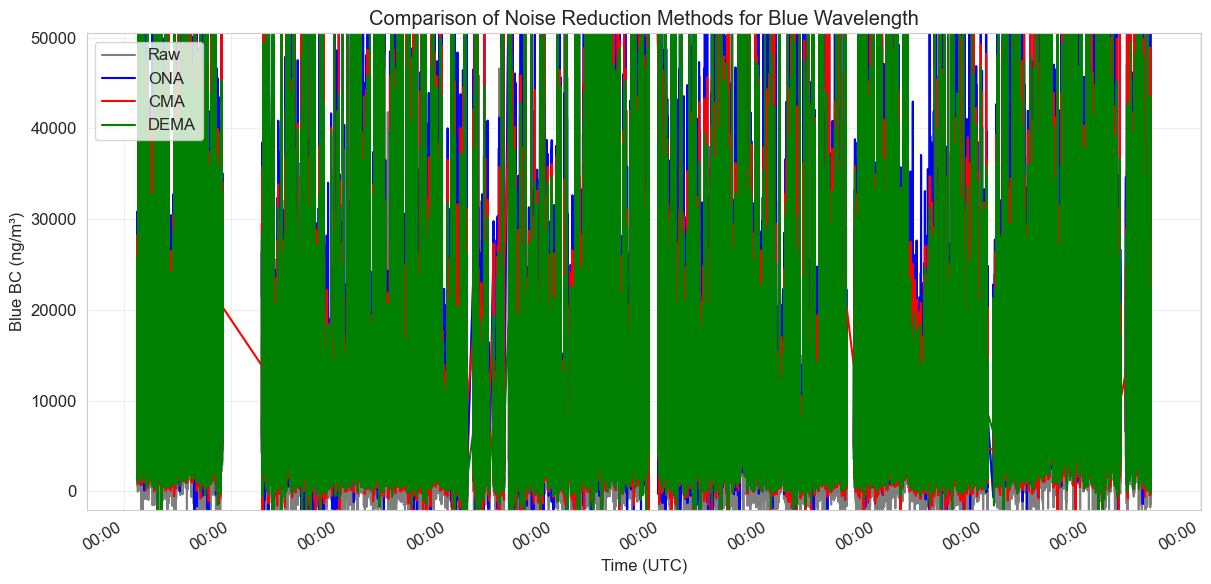


Statistics for Blue wavelength:


shape: (4, 6)
┌────────┬─────────────┬─────────────┬──────────────┬──────────────┬───────────────┐
│ Method ┆ Mean        ┆ Median      ┆ Min          ┆ Max          ┆ Std Dev       │
│ ---    ┆ ---         ┆ ---         ┆ ---          ┆ ---          ┆ ---           │
│ str    ┆ f64         ┆ f64         ┆ f64          ┆ f64          ┆ f64           │
╞════════╪═════════════╪═════════════╪══════════════╪══════════════╪═══════════════╡
│ Raw    ┆ 8491.342376 ┆ 5588.0      ┆ -2.3433e8    ┆ 2.16328672e8 ┆ 318067.804079 │
│ ONA    ┆ 8490.272215 ┆ 5506.0      ┆ -1.1456e8    ┆ 2.16328672e8 ┆ 267699.645548 │
│ CMA    ┆ 8490.510609 ┆ 5621.666667 ┆ -7.6084534e7 ┆ 6.1521e7     ┆ 115301.140692 │
│ DEMA   ┆ 8491.341611 ┆ 5629.600524 ┆ -5.1429e7    ┆ 1.1565e7     ┆ 70318.902527  │
└────────┴─────────────┴─────────────┴──────────────┴──────────────┴───────────────┘


Zoomed view of first 1000 points:


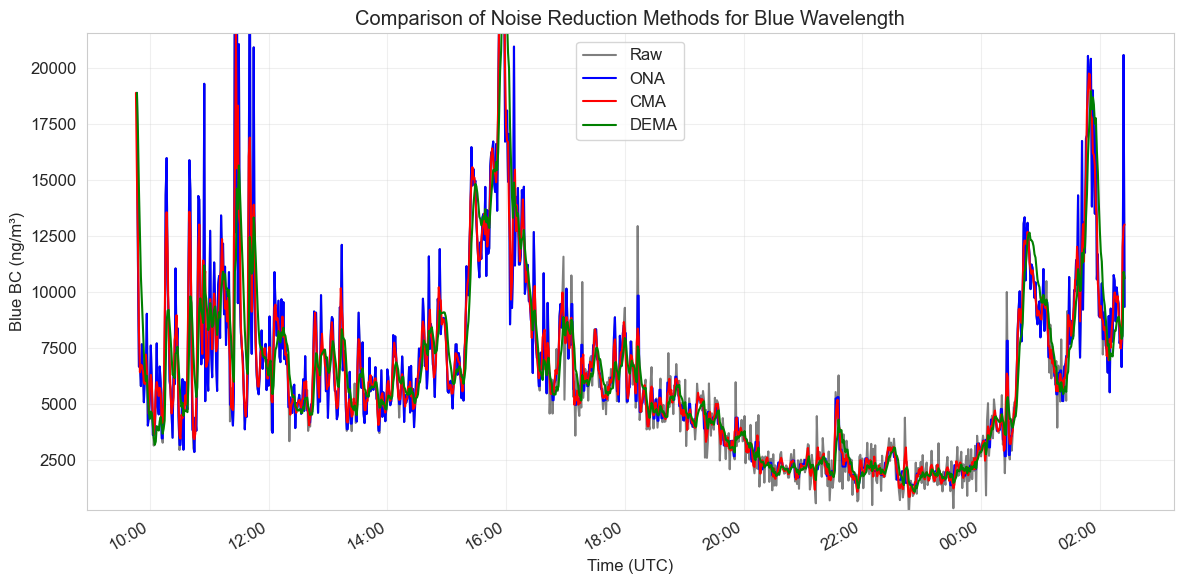


Statistics for Blue wavelength:


shape: (4, 6)
┌────────┬─────────────┬─────────────┬────────────┬──────────────┬─────────────┐
│ Method ┆ Mean        ┆ Median      ┆ Min        ┆ Max          ┆ Std Dev     │
│ ---    ┆ ---         ┆ ---         ┆ ---        ┆ ---          ┆ ---         │
│ str    ┆ f64         ┆ f64         ┆ f64        ┆ f64          ┆ f64         │
╞════════╪═════════════╪═════════════╪════════════╪══════════════╪═════════════╡
│ Raw    ┆ 6286.578579 ┆ 5549.0      ┆ -14.0      ┆ 30867.0      ┆ 4203.535027 │
│ ONA    ┆ 6286.578579 ┆ 5505.0      ┆ 1356.0     ┆ 30867.0      ┆ 4167.572964 │
│ CMA    ┆ 6297.858167 ┆ 5575.333333 ┆ 837.666667 ┆ 28243.666667 ┆ 3932.702108 │
│ DEMA   ┆ 6283.139629 ┆ 5746.332602 ┆ 1061.7537  ┆ 25773.487341 ┆ 3868.1774   │
└────────┴─────────────┴─────────────┴────────────┴──────────────┴─────────────┘


Plots for IR wavelength comparison:


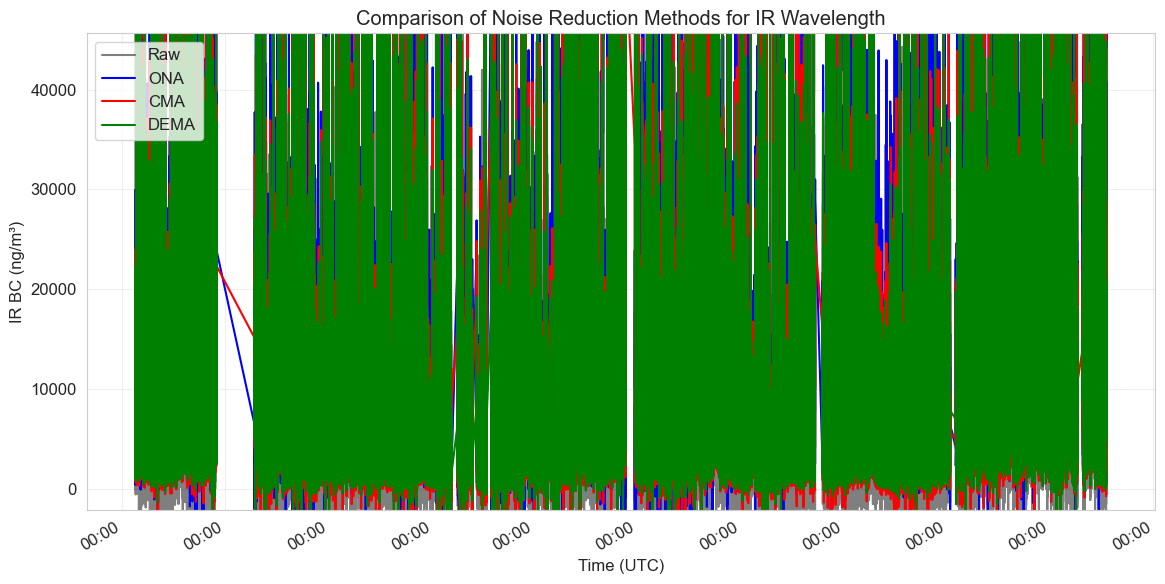


Statistics for IR wavelength:


shape: (4, 6)
┌────────┬─────────────┬─────────────┬───────────────┬───────────────┬─────────────┐
│ Method ┆ Mean        ┆ Median      ┆ Min           ┆ Max           ┆ Std Dev     │
│ ---    ┆ ---         ┆ ---         ┆ ---           ┆ ---           ┆ ---         │
│ str    ┆ f64         ┆ f64         ┆ f64           ┆ f64           ┆ f64         │
╞════════╪═════════════╪═════════════╪═══════════════╪═══════════════╪═════════════╡
│ Raw    ┆ 8137.540267 ┆ 5523.0      ┆ -149717.0     ┆ 547607.0      ┆ 9016.106429 │
│ ONA    ┆ 8136.480605 ┆ 5414.0      ┆ -96787.0      ┆ 547607.0      ┆ 8800.456887 │
│ CMA    ┆ 8136.724637 ┆ 5543.333333 ┆ -45458.333333 ┆ 364823.666667 ┆ 8547.660178 │
│ DEMA   ┆ 8137.537751 ┆ 5556.127436 ┆ -24188.400226 ┆ 214321.506166 ┆ 8455.235615 │
└────────┴─────────────┴─────────────┴───────────────┴───────────────┴─────────────┘


Zoomed view of first 1000 points:


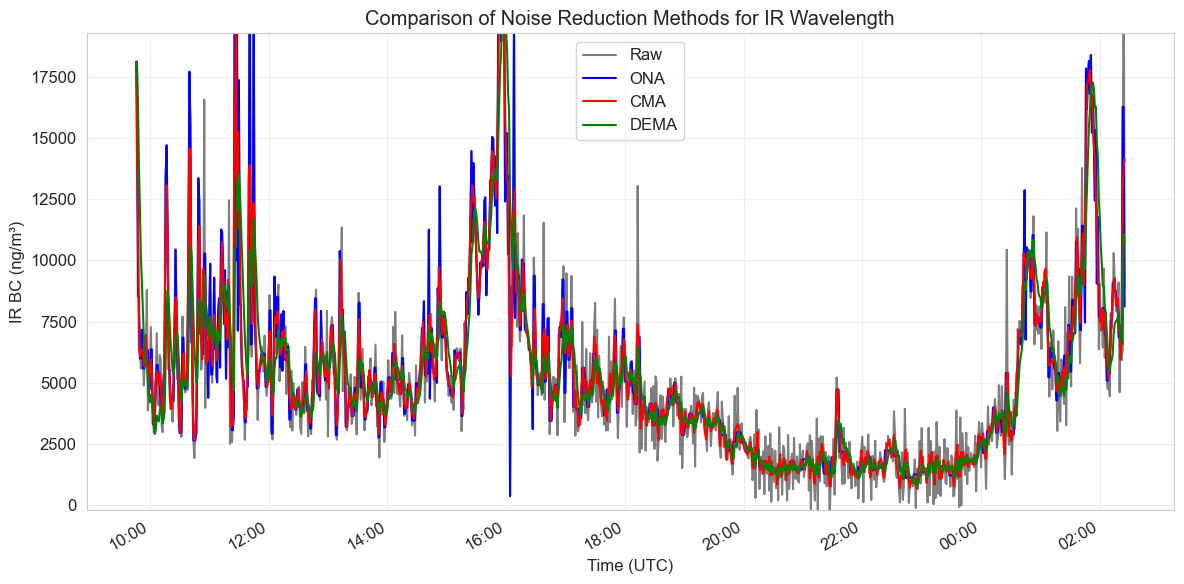


Statistics for IR wavelength:


shape: (4, 6)
┌────────┬─────────────┬─────────────┬────────────┬──────────────┬─────────────┐
│ Method ┆ Mean        ┆ Median      ┆ Min        ┆ Max          ┆ Std Dev     │
│ ---    ┆ ---         ┆ ---         ┆ ---        ┆ ---          ┆ ---         │
│ str    ┆ f64         ┆ f64         ┆ f64        ┆ f64          ┆ f64         │
╞════════╪═════════════╪═════════════╪════════════╪══════════════╪═════════════╡
│ Raw    ┆ 5218.687688 ┆ 4464.0      ┆ -577.0     ┆ 29964.0      ┆ 3855.138772 │
│ ONA    ┆ 5217.954454 ┆ 4608.333333 ┆ 370.0      ┆ 29964.0      ┆ 3700.068118 │
│ CMA    ┆ 5229.878    ┆ 4613.0      ┆ 676.666667 ┆ 24004.0      ┆ 3480.070072 │
│ DEMA   ┆ 5211.230327 ┆ 4621.302718 ┆ 815.561464 ┆ 22281.906269 ┆ 3369.841106 │
└────────┴─────────────┴─────────────┴────────────┴──────────────┴─────────────┘


Source apportionment comparison plots:


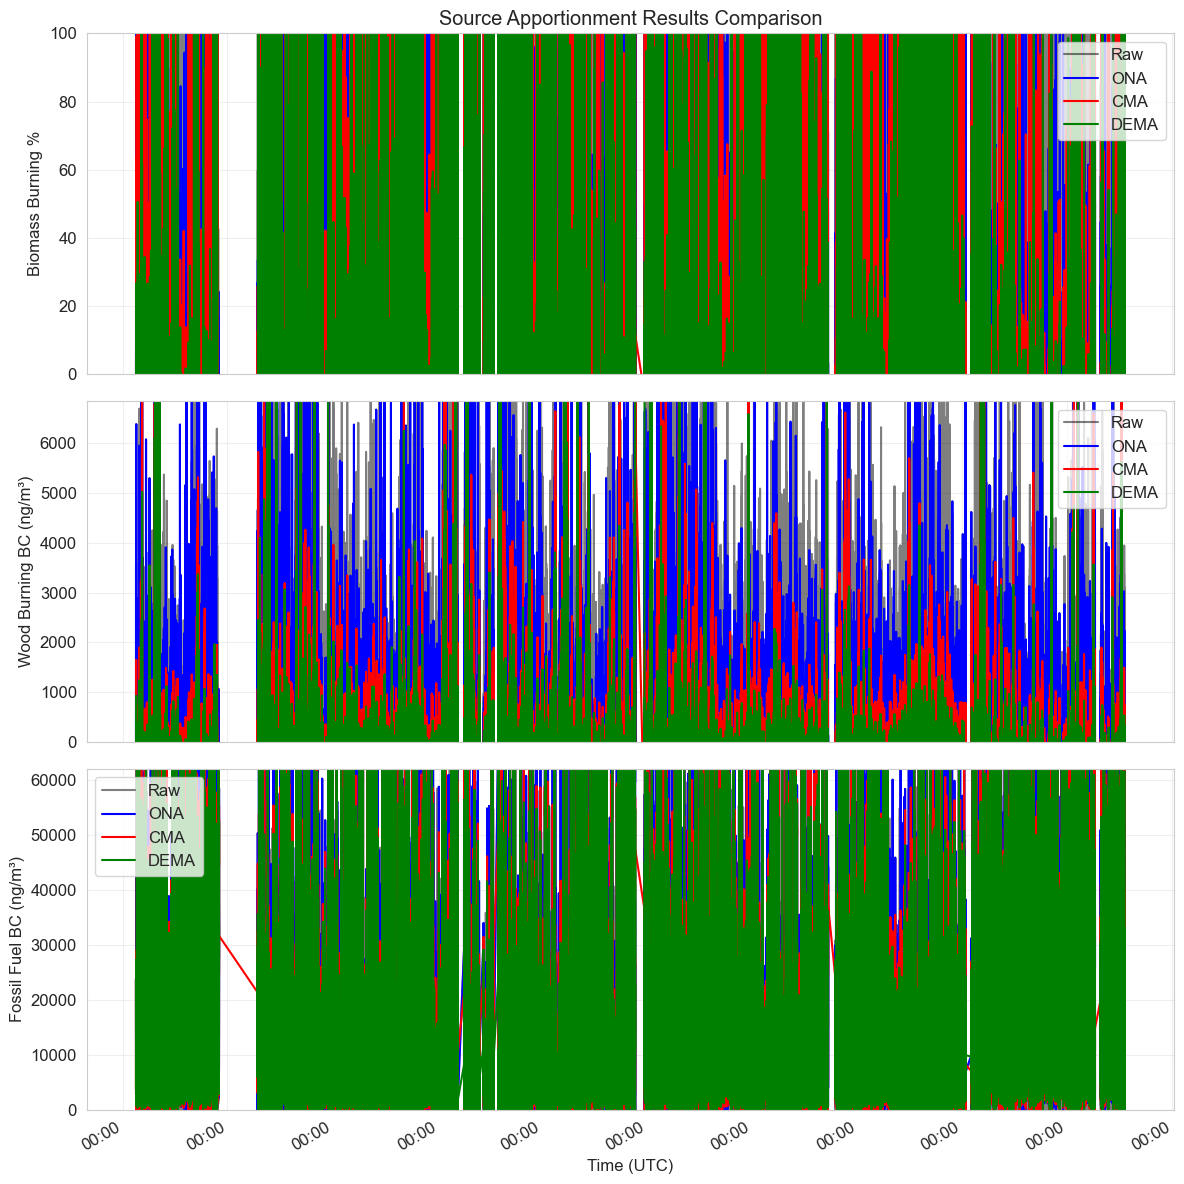


Source Apportionment Statistics:


shape: (12, 7)
┌────────┬────────────┬──────────────┬──────────────┬───────────────┬───────────────┬──────────────┐
│ Method ┆ Component  ┆ Mean         ┆ Median       ┆ Min           ┆ Max           ┆ Std Dev      │
│ ---    ┆ ---        ┆ ---          ┆ ---          ┆ ---           ┆ ---           ┆ ---          │
│ str    ┆ str        ┆ f64          ┆ f64          ┆ f64           ┆ f64           ┆ f64          │
╞════════╪════════════╪══════════════╪══════════════╪═══════════════╪═══════════════╪══════════════╡
│ Raw    ┆ BB_Percent ┆ -26.472931   ┆ -33.575272   ┆ -1.6076e6     ┆ 1.2859e6      ┆ 3375.762898  │
│ Raw    ┆ BC_WB      ┆ -2557.283504 ┆ -1865.540164 ┆ -1.8687e8     ┆ 1.7249e8      ┆ 253553.45185 │
│        ┆            ┆              ┆              ┆               ┆               ┆ 4            │
│ Raw    ┆ BC_FF      ┆ 10694.823771 ┆ 7387.755886  ┆ -1.7248e8     ┆ 1.8688e8      ┆ 253826.62024 │
│        ┆            ┆              ┆              ┆               ┆               ┆ 5            │
│ ONA    ┆ BB_Percent ┆ -22.764069   ┆ -33.043734   ┆ -539834.23291 ┆ 6.8946e6      ┆ 6697.099625  │
│        ┆            ┆              ┆              ┆ 3             ┆               ┆              │
│ ONA    ┆ BC_WB      ┆ -2556.900501 ┆ -1694.23121  ┆ -9.1372e7     ┆ 1.7250e8      ┆ 213388.41012 │
│        ┆            ┆              ┆              ┆               ┆               ┆ 3            │
│ …      ┆ …          ┆ …            ┆ …            ┆ …             ┆ …             ┆ …            │
│ CMA    ┆ BC_WB      ┆ -2556.937509 ┆ -1780.860643 ┆ -6.0683e7     ┆ 4.9053e7      ┆ 91729.141711 │
│ CMA    ┆ BC_FF      ┆ 10693.662145 ┆ 7313.751088  ┆ -4.9049e7     ┆ 6.0694e7      ┆ 92394.071205 │
│ DEMA   ┆ BB_Percent ┆ -29.44112    ┆ -33.214672   ┆ -474158.75664 ┆ 380956.495224 ┆ 1113.763338  │
│        ┆            ┆              ┆              ┆ 4             ┆               ┆              │
│ DEMA   ┆ BC_WB      ┆ -2557.207035 ┆ -1777.031548 ┆ -4.1023e7     ┆ 9.2144e6      ┆ 55710.083279 │
│ DEMA   ┆ BC_FF      ┆ 10694.744787 ┆ 7317.056042  ┆ -9.2079e6     ┆ 4.1033e7      ┆ 56758.967236 │
└────────┴────────────┴──────────────┴──────────────┴───────────────┴───────────────┴──────────────┘


Zoomed view of first 1000 points:


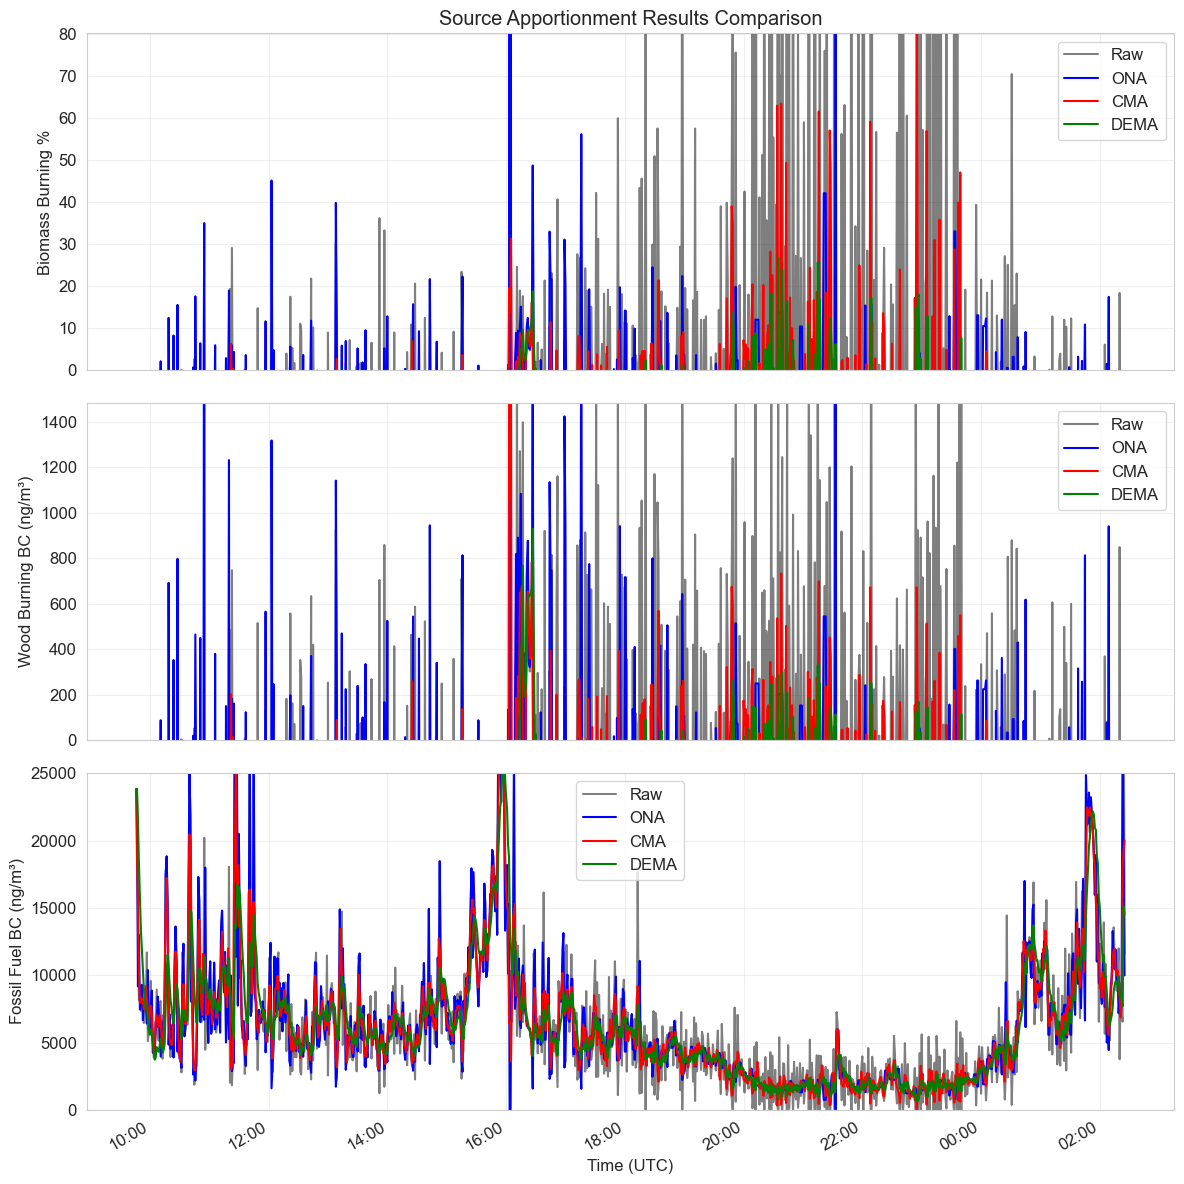


Source Apportionment Statistics:


shape: (12, 7)
┌────────┬────────────┬─────────────┬─────────────┬───────────────┬──────────────┬─────────────┐
│ Method ┆ Component  ┆ Mean        ┆ Median      ┆ Min           ┆ Max          ┆ Std Dev     │
│ ---    ┆ ---        ┆ ---         ┆ ---         ┆ ---           ┆ ---          ┆ ---         │
│ str    ┆ str        ┆ f64         ┆ f64         ┆ f64           ┆ f64          ┆ f64         │
╞════════╪════════════╪═════════════╪═════════════╪═══════════════╪══════════════╪═════════════╡
│ Raw    ┆ BB_Percent ┆ -42.553042  ┆ -17.353741  ┆ -37965.639158 ┆ 3058.269438  ┆ 1213.215077 │
│ Raw    ┆ BC_WB      ┆ -969.336621 ┆ -797.725304 ┆ -13660.514518 ┆ 6385.844869  ┆ 1513.255001 │
│ Raw    ┆ BC_FF      ┆ 6188.024309 ┆ 5202.559736 ┆ -6015.844869  ┆ 42273.802649 ┆ 5136.650233 │
│ ONA    ┆ BB_Percent ┆ -13.672073  ┆ -16.212859  ┆ -80.376483    ┆ 1725.904019  ┆ 57.587043   │
│ ONA    ┆ BC_WB      ┆ -968.496086 ┆ -600.968406 ┆ -12309.802649 ┆ 6385.844869  ┆ 1405.947482 │
│ …      ┆ …          ┆ …           ┆ …           ┆ …             ┆ …            ┆ …           │
│ CMA    ┆ BC_WB      ┆ -973.169939 ┆ -755.6409   ┆ -6216.885891  ┆ 1651.950832  ┆ 1060.967024 │
│ CMA    ┆ BC_FF      ┆ 6203.047939 ┆ 5395.912753 ┆ 5.301043      ┆ 28998.635083 ┆ 4418.430563 │
│ DEMA   ┆ BB_Percent ┆ -16.330175  ┆ -17.542572  ┆ -45.222425    ┆ 26.756401    ┆ 9.57253     │
│ DEMA   ┆ BC_WB      ┆ -963.530236 ┆ -743.64403  ┆ -5716.363751  ┆ 928.731064   ┆ 939.263455  │
│ DEMA   ┆ BC_FF      ┆ 6174.760562 ┆ 5406.517909 ┆ 693.846583    ┆ 27272.211363 ┆ 4210.146405 │
└────────┴────────────┴─────────────┴─────────────┴───────────────┴──────────────┴─────────────┘

In [13]:
# Plot comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    if bc_col in data.columns:
        print(f"\nPlots for {wavelength} wavelength comparison:")
        
        # Plot full dataset
        plot_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength)
        
        # Plot a sample period (first 1000 points or 10% of data, whichever is smaller)
        sample_size = min(1000, int(len(data) * 0.1))
        if sample_size < len(data):
            print(f"\nZoomed view of first {sample_size} points:")
            plot_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength, (0, sample_size))

# Plot source apportionment comparisons
print("\nSource apportionment comparison plots:")
plot_source_apportionment_comparison(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa, processed_data_dema_sa)

# Plot a sample period
sample_size = min(1000, int(len(data) * 0.1))
if sample_size < len(data):
    print(f"\nZoomed view of first {sample_size} points:")
    plot_source_apportionment_comparison(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa, processed_data_dema_sa, (0, sample_size))


## 11. Side-by-Side Visualization Comparison
  
Now let's create a side-by-side comparison of all methods for easier visual comparison.

In [14]:
def plot_side_by_side_comparison(data, data_ona, data_cma, data_dema, wavelength='Blue', sample_period=None, timebase=60):
    """
    Plot raw, ONA, CMA, and DEMA processed BC data in a side-by-side grid layout.
    """

    # ---------- identify columns ------------------------------------------------
    bc_col   = f"{wavelength} BCc"
    ona_col  = f"{wavelength}_BC_ONA"
    cma_col  = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"

    # ---------- assemble available methods --------------------------------------
    methods = []
    if bc_col  in data.columns:       methods.append(("Raw",  data,       bc_col))
    if ona_col in data_ona.columns:   methods.append(("ONA",  data_ona,   ona_col))
    if cma_col in data_cma.columns:   methods.append(("CMA",  data_cma,   cma_col))
    if dema_col in data_dema.columns: methods.append(("DEMA", data_dema,  dema_col))

    # ---------- optionally slice a sample period --------------------------------
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        for name, df, col in methods:
            pl_slice = pl.from_pandas(df).slice(start_idx, end_idx - start_idx)
            plot_methods.append((name, pl_slice.to_pandas(), col))
    else:
        plot_methods = methods

    # ---------- guard clause ----------------------------------------------------
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return

    # ---------- figure layout ---------------------------------------------------
    total_panels = n_methods + 1          # +1 for the comparison panel
    n_rows = int(np.ceil(np.sqrt(total_panels)))
    n_cols = int(np.ceil(total_panels / n_rows))
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 5, n_rows * 4),
        sharex=True, sharey=True
    )
    axes = np.array(axes).flatten()

    # ---------- x-axis ----------------------------------------------------------
    if "Time (UTC)" in plot_methods[0][1].columns:
        try:
            x = pd.to_datetime(plot_methods[0][1]["Time (UTC)"])
            x_label = "Time (UTC)"
            formatter = mdates.DateFormatter("%H:%M")
            for ax in axes:
                ax.xaxis.set_major_formatter(formatter)
            fig.autofmt_xdate()
        except Exception:
            x = np.arange(len(plot_methods[0][1]))
            x_label = "Data Point"
    else:
        x = np.arange(len(plot_methods[0][1]))
        x_label = "Data Point"

    # ---------- y-limits (fixed) ------------------------------------------------
    all_y_values = []
    for _, plot_data, col in plot_methods:
        pl_data = pl.from_pandas(plot_data[[col]])
        valid_vals = (
            pl_data
            .filter(~pl.col(col).is_null())
            .select(pl.col(col).alias("value"))            # <<< rename here
        )
        if valid_vals.height > 0:
            all_y_values.append(valid_vals)

    if all_y_values:
        combined = pl.concat(all_y_values)                 # now columns match
        p01, p99 = combined.select(
            pl.col("value").quantile(0.01).alias("p01"),
            pl.col("value").quantile(0.99).alias("p99")
        ).row(0)
        y_buffer = (p99 - p01) * 0.10
        ylim = (p01 - y_buffer, p99 + y_buffer)
    else:
        ylim = (0, 1)

    # ---------- individual panels ----------------------------------------------
    for i, (name, plot_data, col) in enumerate(plot_methods):
        title = "Raw data" if name == "Raw" else f"{name} processed"
        title += f" ({timebase}s)"
        colour = {"Raw": "k", "ONA": "b", "CMA": "r", "DEMA": "g"}[name]
        axes[i].plot(x, plot_data[col], f"{colour}-", label=name, alpha=0.8)
        axes[i].set_title(title)
        axes[i].set_ylabel(f"{wavelength} BC (ng/m³)")
        axes[i].set_ylim(ylim)
        axes[i].grid(True, alpha=0.3)

    # ---------- comparison panel ------------------------------------------------
    comp_idx = n_methods
    for name, plot_data, col in plot_methods:
        colour = {"Raw": "k", "ONA": "b", "CMA": "r", "DEMA": "g"}[name]
        alpha  = 0.5 if name == "Raw" else 0.8
        axes[comp_idx].plot(x, plot_data[col], f"{colour}-", label=name, alpha=alpha)

    axes[comp_idx].set_title("All methods comparison")
    axes[comp_idx].set_xlabel(x_label)
    axes[comp_idx].set_ylabel(f"{wavelength} BC (ng/m³)")
    axes[comp_idx].set_ylim(ylim)
    axes[comp_idx].grid(True, alpha=0.3)
    axes[comp_idx].legend()

    # ---------- tidy up ---------------------------------------------------------
    for j in range(total_panels, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.suptitle(
        f"Side-by-Side Comparison of Processing Methods ({wavelength} Wavelength)",
        y=1.02,
        fontsize=16
    )
    plt.figtext(
        0.5,
        -0.01,
        "Methods: Raw = Original; ONA = Optimized Noise Algorithm; "
        "CMA = Centered Moving Average; DEMA = Double Exponential Moving Average",
        ha="center",
        fontsize=10,
        wrap=True
    )
    plt.show()

    # ---------- optional: return summary stats ----------------------------------
    stats_frames = []
    for name, plot_data, col in plot_methods:
        stats_frames.append(
            pl.from_pandas(plot_data[[col]]).select(
                pl.lit(name).alias("Method"),
                pl.lit(wavelength).alias("Wavelength"),
                pl.col(col).mean().alias("Mean"),
                pl.col(col).median().alias("Median"),
                pl.col(col).min().alias("Min"),
                pl.col(col).max().alias("Max"),
                pl.col(col).std().alias("Std Dev"),
            )
        )
    return pl.concat(stats_frames) if stats_frames else None

In [17]:
def plot_source_apportionment_side_by_side(data_raw, data_ona, data_cma, data_dema, sample_period=None, timebase=60):
    """
    Plot source apportionment results in a side-by-side grid layout
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    timebase : int
        The timebase in seconds (5, 10, 30, 60, etc.)
    """
    # Determine which methods have source apportionment data
    methods = []
    if 'BB_Percent' in data_raw.columns:
        methods.append(('Raw', data_raw))
    if 'BB_Percent' in data_ona.columns:
        methods.append(('ONA', data_ona))
    if 'BB_Percent' in data_cma.columns:
        methods.append(('CMA', data_cma))
    if 'BB_Percent' in data_dema.columns:
        methods.append(('DEMA', data_dema))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas()))
    else:
        plot_methods = methods
    
    # Determine number of panels needed (number of methods + 1 for comparison)
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    total_panels = n_methods + 1  # Include comparison panel
    
    # Calculate grid dimensions (approximately square)
    n_rows = int(np.ceil(np.sqrt(total_panels)))
    n_cols = int(np.ceil(total_panels / n_rows))
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharex=True, sharey=True)
    
    # Handle the case of a single row or column
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes]) 
    
    # Flatten for easier indexing
    axes = axes.flatten()
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits for BB percentage
    all_bb_values = []
    for name, plot_data in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        
        # Get valid values (non-null)
        valid_values = pl_data.filter(~pl.col('BB_Percent').is_null())
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            all_bb_values.append(valid_values.select(pl.col('BB_Percent')))
    
    if all_bb_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_bb_values)
        
        # Calculate percentiles with clipping to 0-100 range
        # MODIFIED SECTION
        percentiles = combined_values.select([
            pl.max_horizontal([pl.col('BB_Percent').quantile(0.01), pl.lit(0)]).alias("p01"),
            pl.min_horizontal([pl.col('BB_Percent').quantile(0.99), pl.lit(100)]).alias("p99")
        ])
        # END MODIFIED SECTION
        
        ymin_bb = percentiles[0, 0]  # 1st percentile, but not below 0
        ymax_bb = percentiles[0, 1]  # 99th percentile, but not above 100
        
        # Add a small buffer to the y-limits for visual clarity
        y_buffer_bb = (ymax_bb - ymin_bb) * 0.1
        ylim_bb = (max(0, ymin_bb - y_buffer_bb), min(100, ymax_bb + y_buffer_bb))
    else:
        ylim_bb = (0, 100)  # Default range for BB%
    
    # Plot titles and data for individual methods
    for i, (name, plot_data) in enumerate(plot_methods):
        title = f'{name} processed ({timebase}s)'
        if name == 'Raw':
            title = f'Raw data ({timebase}s)'
            axes[i].plot(x, plot_data['BB_Percent'], 'k-', label=name)
        elif name == 'ONA':
            axes[i].plot(x, plot_data['BB_Percent'], 'b-', label=name)
        elif name == 'CMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'r-', label=name)
        elif name == 'DEMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'g-', label=name)
        
        axes[i].set_title(title)
        axes[i].set_ylabel('Biomass Burning %')
        axes[i].set_ylim(ylim_bb)
        axes[i].grid(True, alpha=0.3)
    
    # Use the comparison panel (should be the next one after all individual method panels)
    comp_idx = n_methods  # This should be the index for the comparison panel
    
    # Plot all methods for comparison in the comparison panel
    for name, plot_data in plot_methods:
        if name == 'Raw':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'k-', alpha=0.5, label=name)
        elif name == 'ONA':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'b-', label=name)
        elif name == 'CMA':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'r-', label=name)
        elif name == 'DEMA':
            axes[comp_idx].plot(x, plot_data['BB_Percent'], 'g-', label=name)
    
    axes[comp_idx].set_title('All methods comparison')
    axes[comp_idx].set_ylabel('Biomass Burning %')
    axes[comp_idx].set_xlabel(x_label)
    axes[comp_idx].set_ylim(ylim_bb)
    axes[comp_idx].grid(True, alpha=0.3)
    axes[comp_idx].legend()
    
    # Hide any extra subplots
    for i in range(total_panels, len(axes)):
        axes[i].set_visible(False)
    
    if x_label == 'Time (UTC)':
        fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.suptitle('Side-by-Side Comparison of Source Apportionment Results', y=1.02, fontsize=16)
    
    # Add method information in the figure footer
    plt.figtext(0.5, -0.01, 
                "Biomass Burning (BB) % shows the proportion of black carbon from wood/biomass combustion vs. fossil fuels", 
                ha='center', fontsize=10, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics about source apportionment
    stats_data = []
    for name, plot_data in plot_methods:
        # Use Polars for efficient stats calculation
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        stats = pl_data.select([
            pl.lit(name).alias("Method"),
            pl.col('BB_Percent').mean().alias("Mean BB%"),
            pl.col('BB_Percent').median().alias("Median BB%"),
            pl.col('BB_Percent').min().alias("Min BB%"),
            pl.col('BB_Percent').max().alias("Max BB%"),
            pl.col('BB_Percent').std().alias("Std Dev BB%")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None


Side-by-side comparison for Blue wavelength:


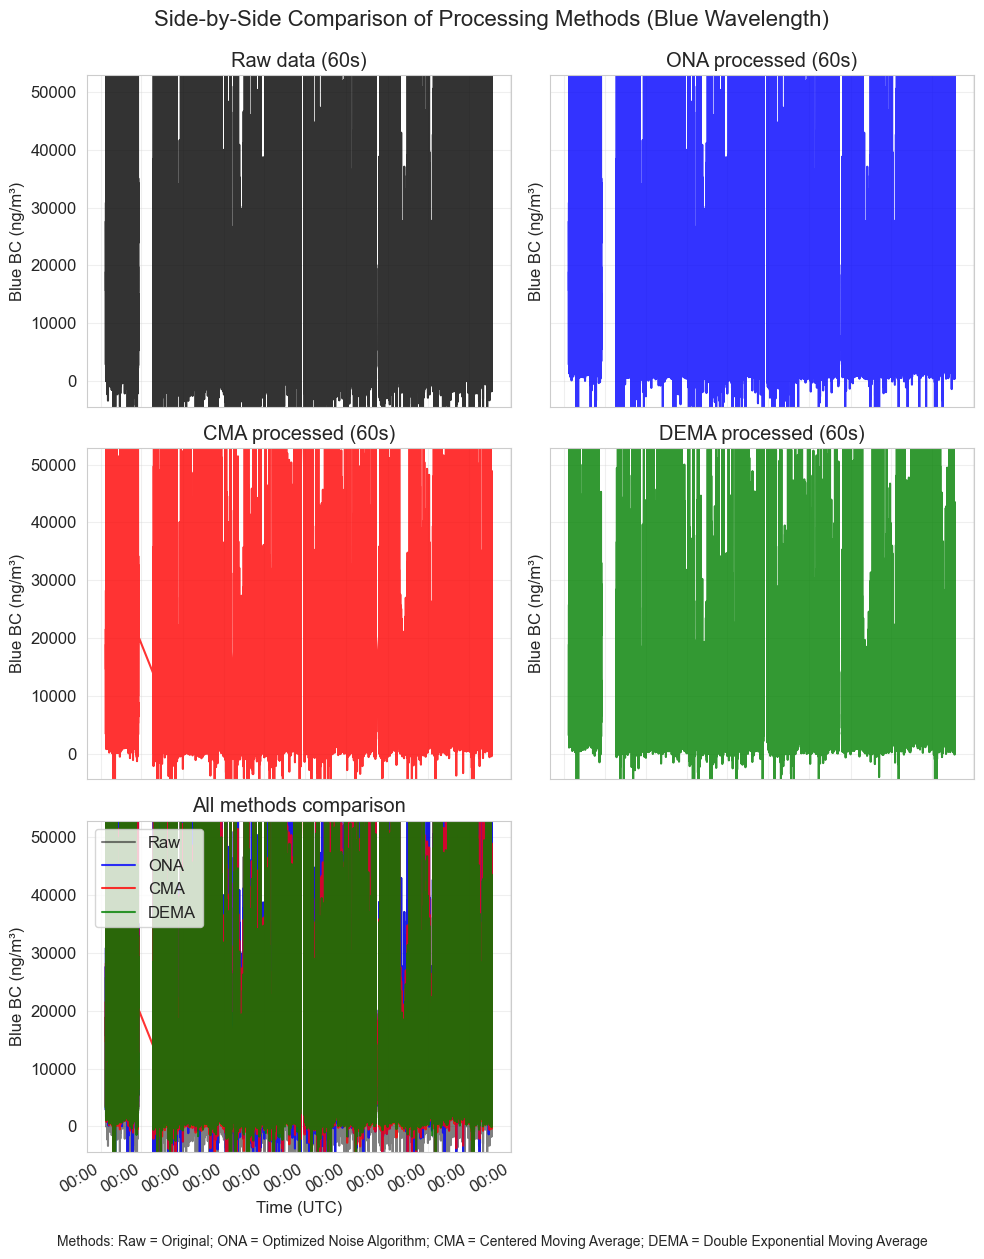


Zoomed view of first 1000 points:


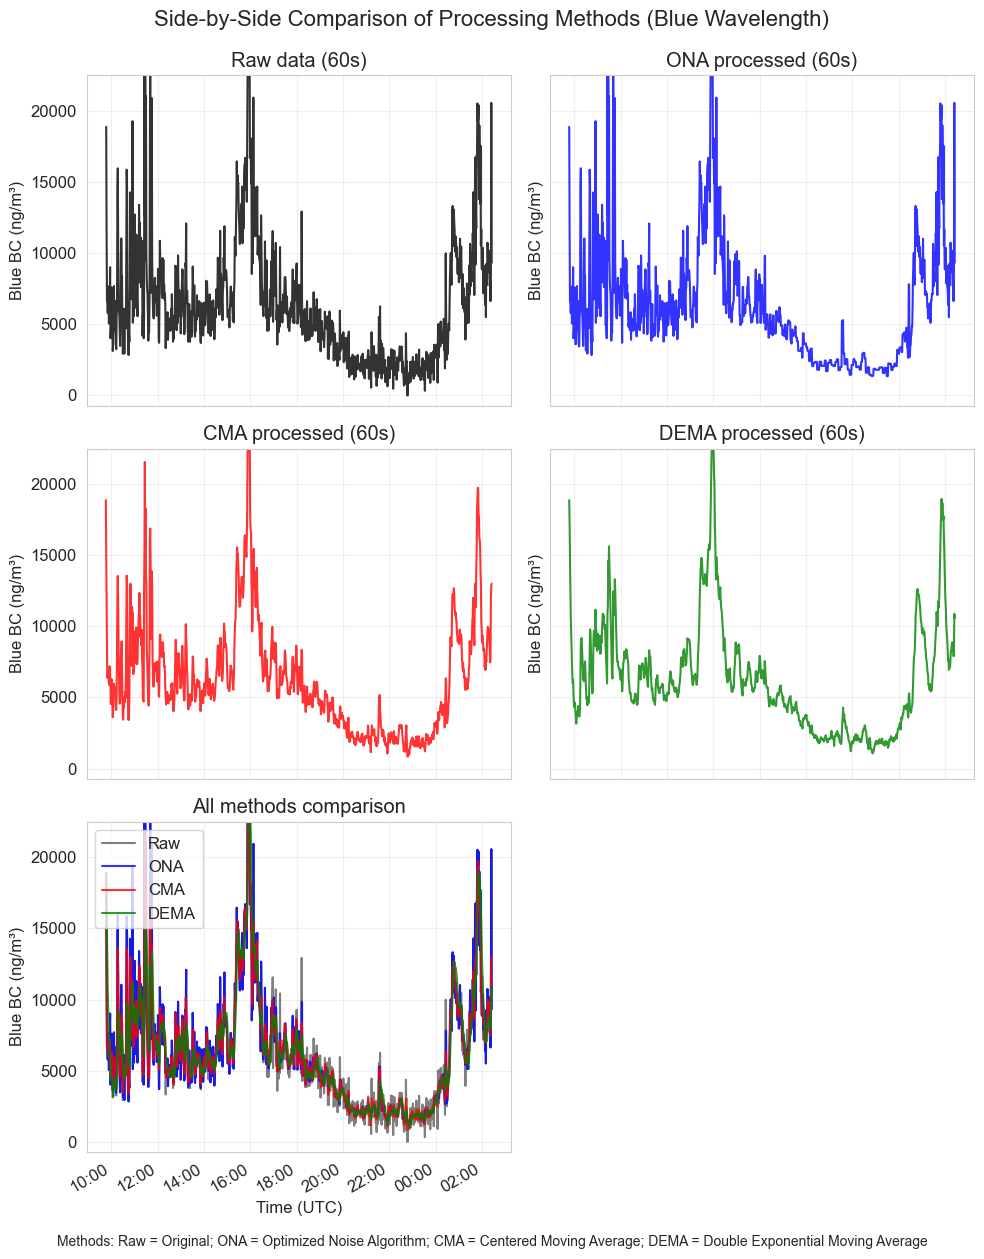


Side-by-side comparison for IR wavelength:


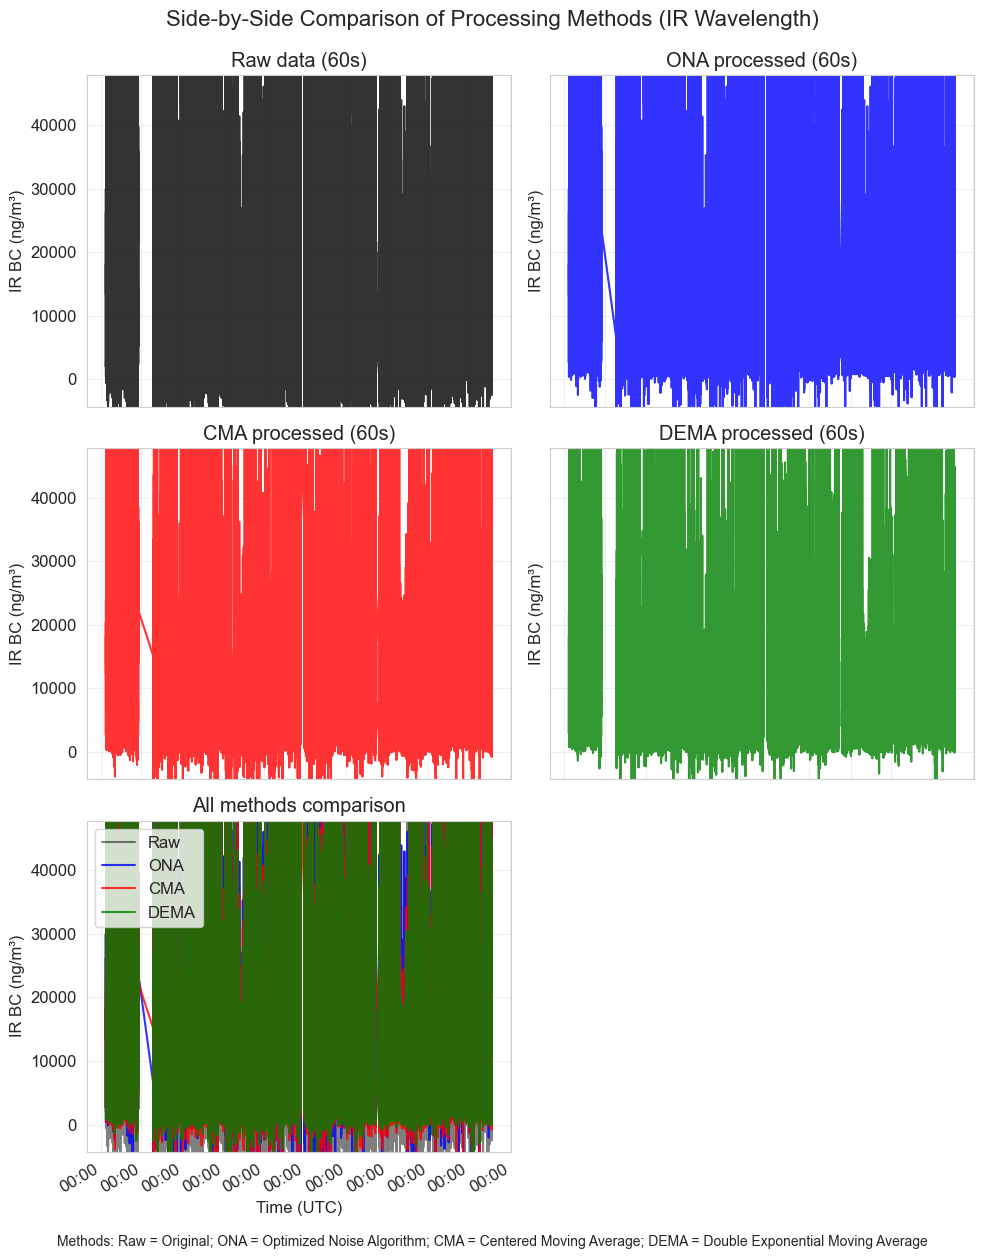


Zoomed view of first 1000 points:


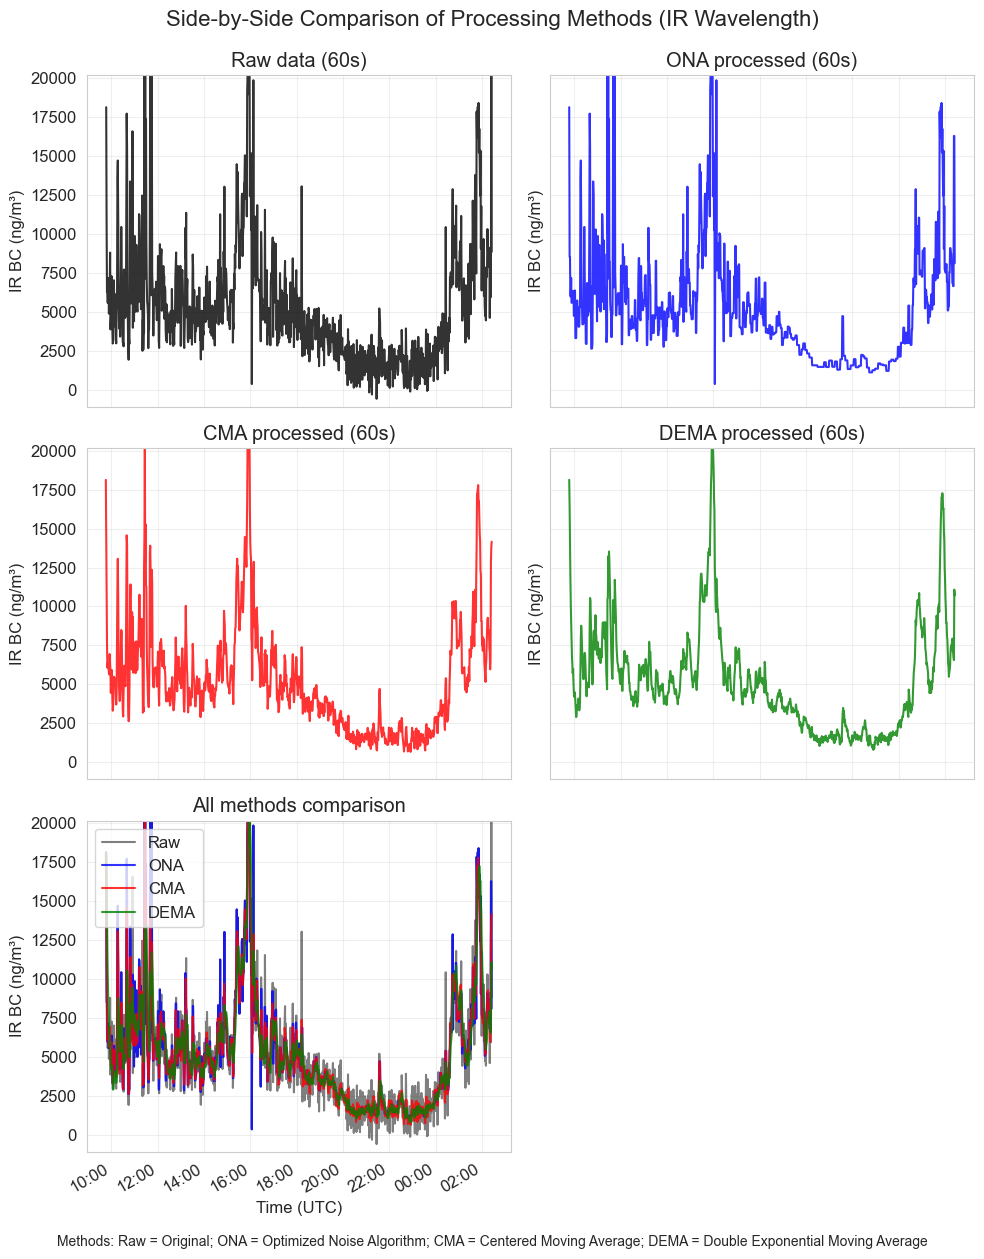


Side-by-side source apportionment comparison:


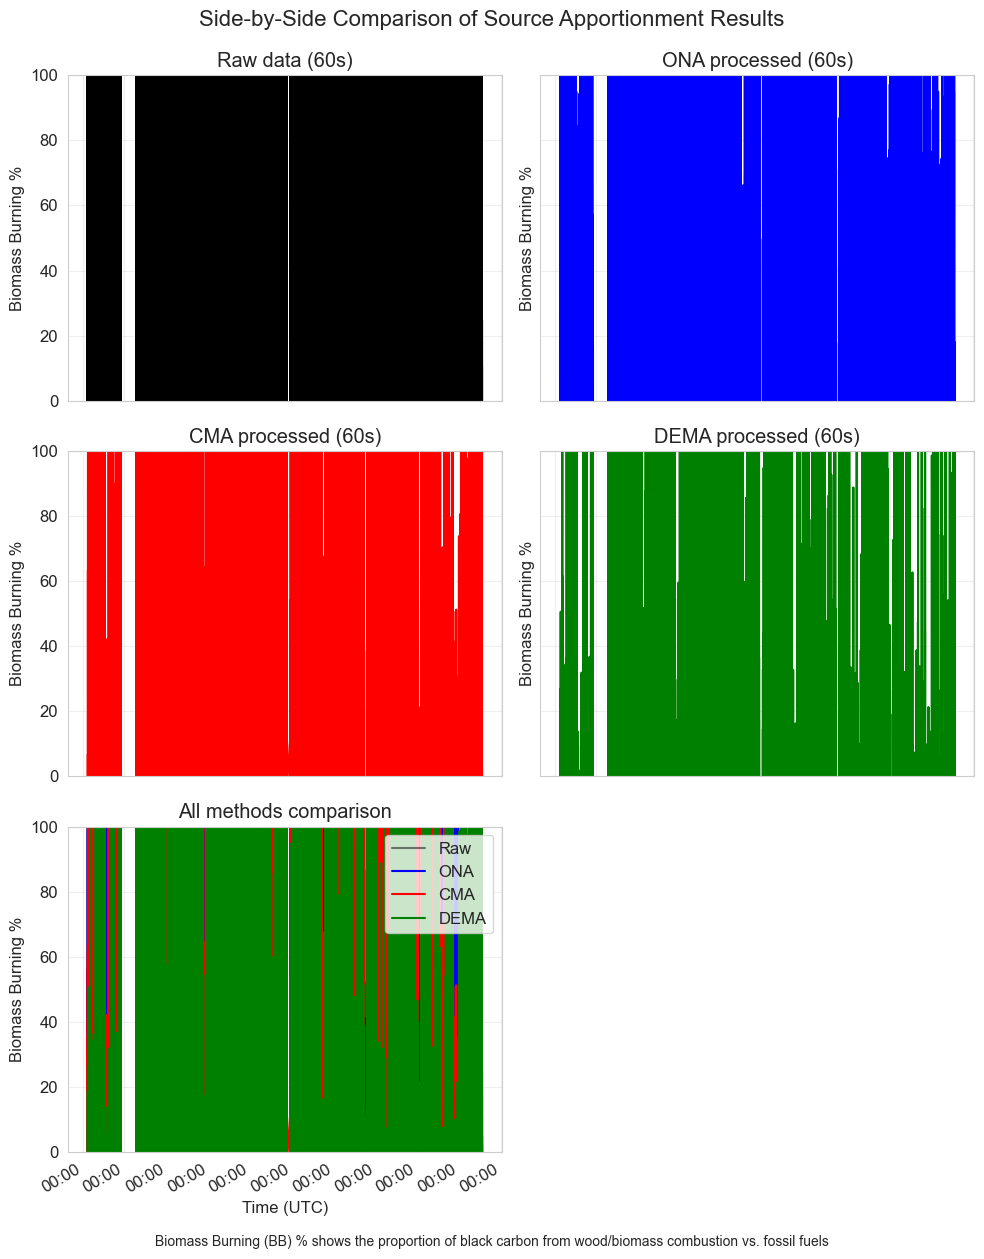


Source Apportionment Statistics:


shape: (4, 6)
┌────────┬────────────┬────────────┬────────────────┬───────────────┬─────────────┐
│ Method ┆ Mean BB%   ┆ Median BB% ┆ Min BB%        ┆ Max BB%       ┆ Std Dev BB% │
│ ---    ┆ ---        ┆ ---        ┆ ---            ┆ ---           ┆ ---         │
│ str    ┆ f64        ┆ f64        ┆ f64            ┆ f64           ┆ f64         │
╞════════╪════════════╪════════════╪════════════════╪═══════════════╪═════════════╡
│ Raw    ┆ -26.472931 ┆ -33.575272 ┆ -1.6076e6      ┆ 1.2859e6      ┆ 3375.762898 │
│ ONA    ┆ -22.764069 ┆ -33.043734 ┆ -539834.232913 ┆ 6.8946e6      ┆ 6697.099625 │
│ CMA    ┆ -28.722768 ┆ -32.992338 ┆ -584375.02559  ┆ 1.1052e6      ┆ 1912.860473 │
│ DEMA   ┆ -29.44112  ┆ -33.214672 ┆ -474158.756644 ┆ 380956.495224 ┆ 1113.763338 │
└────────┴────────────┴────────────┴────────────────┴───────────────┴─────────────┘


Zoomed view of first 1000 points for source apportionment:


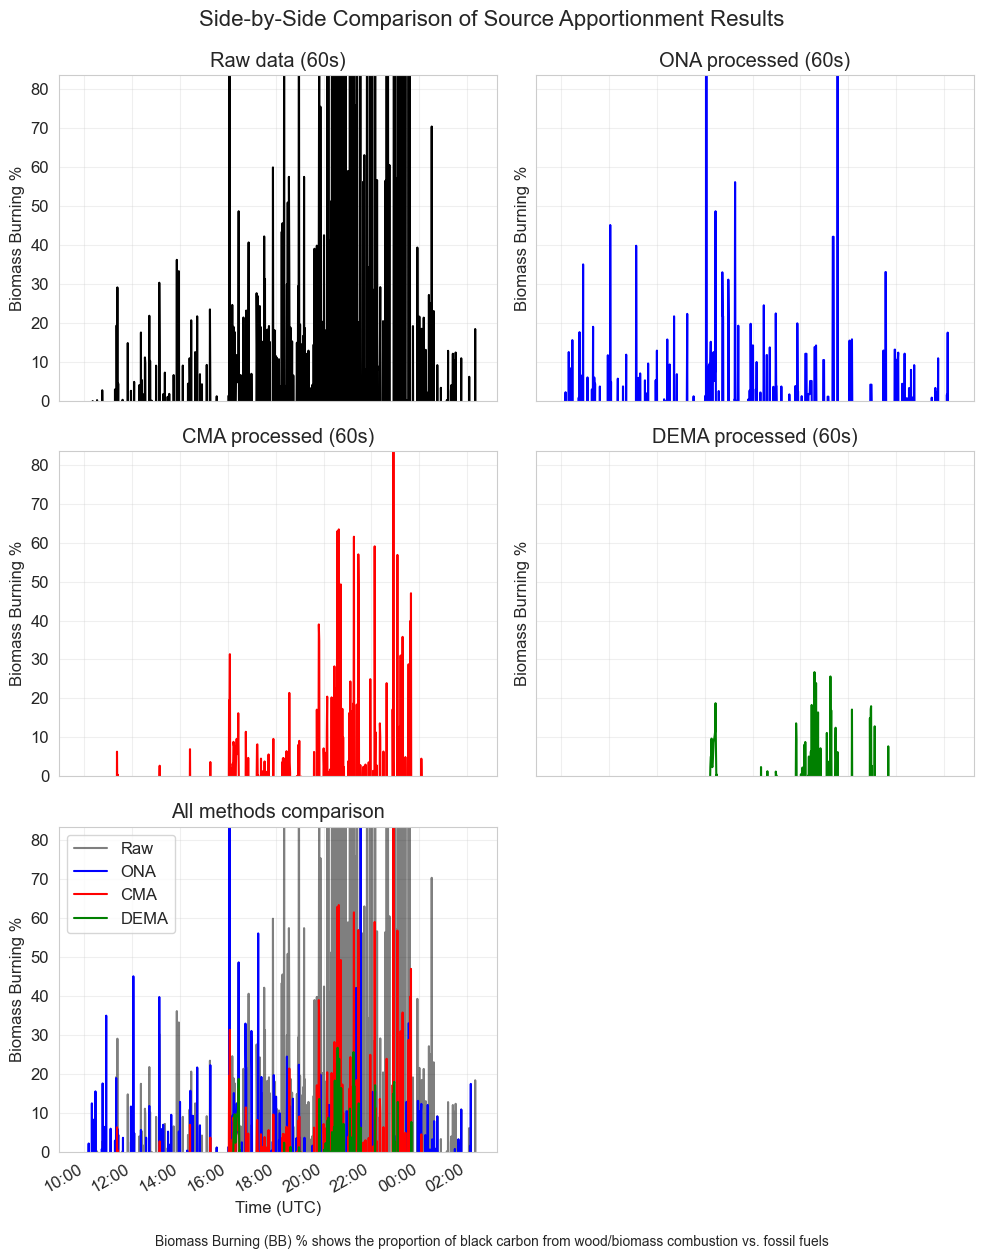


Zoomed Source Apportionment Statistics:


shape: (4, 6)
┌────────┬────────────┬────────────┬───────────────┬─────────────┬─────────────┐
│ Method ┆ Mean BB%   ┆ Median BB% ┆ Min BB%       ┆ Max BB%     ┆ Std Dev BB% │
│ ---    ┆ ---        ┆ ---        ┆ ---           ┆ ---         ┆ ---         │
│ str    ┆ f64        ┆ f64        ┆ f64           ┆ f64         ┆ f64         │
╞════════╪════════════╪════════════╪═══════════════╪═════════════╪═════════════╡
│ Raw    ┆ -42.553042 ┆ -17.353741 ┆ -37965.639158 ┆ 3058.269438 ┆ 1213.215077 │
│ ONA    ┆ -13.672073 ┆ -16.212859 ┆ -80.376483    ┆ 1725.904019 ┆ 57.587043   │
│ CMA    ┆ -15.351622 ┆ -17.533887 ┆ -53.04398     ┆ 99.216595   ┆ 14.588927   │
│ DEMA   ┆ -16.330175 ┆ -17.542572 ┆ -45.222425    ┆ 26.756401   ┆ 9.57253     │
└────────┴────────────┴────────────┴───────────────┴─────────────┴─────────────┘

In [18]:
# Determine the timebase from the data using Polars
pl_data = pl.from_pandas(data)
if 'Timebase (s)' in pl_data.columns:
    timebase = pl_data.select(pl.col('Timebase (s)')).row(0)[0]
else:
    timebase = 60  # default assumption

# Plot side-by-side comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    
    if bc_col in pl_data.columns:
        print(f"\nSide-by-side comparison for {wavelength} wavelength:")
        
        # Plot full dataset
        plot_side_by_side_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema,
                                  wavelength, timebase=timebase)
        
        # Calculate sample size using Polars for efficiency
        data_length = pl_data.height
        sample_size = min(1000, int(data_length * 0.1))
        
        if sample_size < data_length:
            print(f"\nZoomed view of first {sample_size} points:")
            plot_side_by_side_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema,
                                      wavelength, (0, sample_size), timebase=timebase)

# Plot source apportionment comparisons
print("\nSide-by-side source apportionment comparison:")
sa_stats = plot_source_apportionment_side_by_side(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa,
                                     processed_data_dema_sa, timebase=timebase)

# If statistics were returned, display them
if sa_stats is not None:
    print("\nSource Apportionment Statistics:")
    display(sa_stats)

# Plot a sample period for source apportionment using the same sample size for consistency
if sample_size < data_length:
    print(f"\nZoomed view of first {sample_size} points for source apportionment:")
    sa_zoom_stats = plot_source_apportionment_side_by_side(processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa,
                                        processed_data_dema_sa, (0, sample_size), timebase=timebase)
    
    # If zoom statistics were returned, display them
    if sa_zoom_stats is not None:
        print("\nZoomed Source Apportionment Statistics:")
        display(sa_zoom_stats)

## 12. Stacked Temporal Comparison
  
Let's also create a visualization that stacks the temporal plots vertically for each processing method.

In [23]:
def plot_stacked_temporal_comparison(data, data_ona, data_cma, data_dema, wavelength='Blue', sample_period=None):
    """
    Plot stacked temporal comparison of raw, ONA, CMA, and DEMA processed BC data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to plot
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Determine which methods are available
    methods = []
    if bc_col in data.columns:
        methods.append(('Raw', data, bc_col))
    if ona_col in data_ona.columns:
        methods.append(('ONA', data_ona, ona_col))
    if cma_col in data_cma.columns:
        methods.append(('CMA', data_cma, cma_col))
    if dema_col in data_dema.columns:
        methods.append(('DEMA', data_dema, dema_col))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df, col in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas(), col))
    else:
        plot_methods = methods
    
    # Determine number of panels needed
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    # Create a figure with vertically stacked subplots
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, n_methods*3), sharex=True)
    if n_methods == 1:
        axes = [axes]  # Make it a list for consistent indexing
    
    # Determine the timebase using Polars for efficiency
    if 'Timebase (s)' in plot_methods[0][1].columns:
        # Convert to Polars for efficient access
        pl_first_data = pl.from_pandas(plot_methods[0][1][['Timebase (s)']])
        timebase = pl_first_data.select(pl.col('Timebase (s)')).row(0)[0]
    else:
        timebase = 60  # default
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits
    all_y_values = []
    for name, plot_data, col in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_df = pl.from_pandas(plot_data[[col]]) # Corrected from pl_data to pl_df
        
        # Get valid values (non-null)
        valid_values = pl_df.filter(~pl.col(col).is_null()) # Corrected from pl_data to pl_df
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            # >>> Corrected line: Alias the column to a common name "value"
            all_y_values.append(valid_values.select(pl.col(col).alias("value")))
    
    if all_y_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_y_values)
        
        # Calculate percentiles
        # >>> Corrected lines: Use the aliased column name "value"
        percentiles = combined_values.select([
            pl.col("value").quantile(0.01).alias("p01"),
            pl.col("value").quantile(0.99).alias("p99")
        ])
        
        ymin = percentiles[0, "p01"]  # Access by alias
        ymax = percentiles[0, "p99"]  # Access by alias
        
        # Ensure min and max are different to prevent division by zero
        if ymin == ymax:
            ymin -= 10
            ymax += 10
            
        # Add a small buffer to the y-limits for visual clarity
        y_buffer = (ymax - ymin) * 0.1
        ylim = (ymin - y_buffer, ymax + y_buffer)
    else:
        ylim = (0, 1)  # Default if no valid values
    
    # Plot data for each method
    for i, (name, plot_data, col) in enumerate(plot_methods):
        if name == 'Raw':
            axes[i].plot(x, plot_data[col], 'k-', label=f'Raw ({timebase}s)')
        elif name == 'ONA':
            axes[i].plot(x, plot_data[col], 'b-', label=f'ONA ({timebase}s)')
        elif name == 'CMA':
            axes[i].plot(x, plot_data[col], 'r-', label=f'CMA ({timebase}s)')
        elif name == 'DEMA':
            axes[i].plot(x, plot_data[col], 'g-', label=f'DEMA ({timebase}s)')
        
        axes[i].set_ylabel(f'{wavelength} BC (ng/m³)')
        axes[i].legend(loc='upper right')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(ylim)
    
    axes[-1].set_xlabel(x_label)
    plt.suptitle(f'Stacked Temporal Comparison ({wavelength} Wavelength)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    # Add descriptive text about the methods
    method_descriptions = {
        'Raw': 'Unprocessed data',
        'ONA': 'Optimized Noise-reduction Algorithm (adaptive time-averaging based on ΔATN)',
        'CMA': 'Centered Moving Average (fixed window smoothing)',
        'DEMA': 'Double Exponentially Weighted Moving Average (reduces noise with minimal lag)'
    }
    
    available_method_names = [name for name, _, _ in plot_methods]
    description_text = " | ".join([f"{name}: {method_descriptions[name]}" for name in available_method_names])
    
    plt.figtext(0.5, -0.01, description_text, ha='center', fontsize=9, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics for each method
    stats_data = []
    for name, plot_data, col in plot_methods:
        # Use Polars for efficient stats calculation
        pl_df_stats = pl.from_pandas(plot_data[[col]]) # Corrected from pl_data to pl_df_stats
        stats = pl_df_stats.select([ # Corrected from pl_data to pl_df_stats
            pl.lit(name).alias("Method"),
            pl.lit(wavelength).alias("Wavelength"),
            pl.col(col).mean().alias("Mean"),
            pl.col(col).median().alias("Median"),
            pl.col(col).min().alias("Min"),
            pl.col(col).max().alias("Max"),
            pl.col(col).std().alias("Std Dev")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None

In [26]:
def plot_stacked_source_apportionment(data_raw, data_ona, data_cma, data_dema, sample_period=None):
    """
    Plot stacked temporal comparison of source apportionment results
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Determine which methods have source apportionment data
    methods = []
    if 'BB_Percent' in data_raw.columns:
        methods.append(('Raw', data_raw))
    if 'BB_Percent' in data_ona.columns:
        methods.append(('ONA', data_ona))
    if 'BB_Percent' in data_cma.columns:
        methods.append(('CMA', data_cma))
    if 'BB_Percent' in data_dema.columns:
        methods.append(('DEMA', data_dema))
    
    # Use Polars for efficient data selection if sample period is specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_methods = []
        
        for name, df in methods:
            # Convert to Polars for efficient slicing
            pl_df = pl.from_pandas(df)
            
            # Slice the data
            pl_slice = pl_df.slice(start_idx, end_idx - start_idx)
            
            # Convert back to pandas for plotting
            plot_methods.append((name, pl_slice.to_pandas()))
    else:
        plot_methods = methods
    
    # Determine number of panels needed
    n_methods = len(plot_methods)
    if n_methods < 2:
        print("Not enough methods to compare")
        return
    
    # Create a figure with vertically stacked subplots
    fig, axes = plt.subplots(n_methods, 1, figsize=(12, n_methods*3), sharex=True)
    if n_methods == 1:
        axes = [axes]  # Make it a list for consistent indexing
    
    # Determine the timebase using Polars for efficiency
    if 'Timebase (s)' in plot_methods[0][1].columns:
        # Convert to Polars for efficient access
        pl_first_data = pl.from_pandas(plot_methods[0][1][['Timebase (s)']])
        timebase = pl_first_data.select(pl.col('Timebase (s)')).row(0)[0]
    else:
        timebase = 60  # default
    
    # Create x-axis values - use first dataset for reference
    if 'Time (UTC)' in plot_methods[0][1].columns:
        try:
            # Convert time column to datetime using pandas
            x = pd.to_datetime(plot_methods[0][1]['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
            for ax in axes:
                ax.xaxis.set_major_formatter(x_formatter)
            fig.autofmt_xdate()
        except:
            # If datetime conversion fails, use index
            x = np.arange(len(plot_methods[0][1]))
            x_label = 'Data Point'
    else:
        # If no time column, use index
        x = np.arange(len(plot_methods[0][1]))
        x_label = 'Data Point'
    
    # Use Polars for efficient calculation of y-limits for BB percentage
    all_bb_values = []
    for name, plot_data in plot_methods:
        # Convert to Polars for more efficient filtering
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        
        # Get valid values (non-null)
        valid_values = pl_data.filter(~pl.col('BB_Percent').is_null())
        
        # Add to the list if there are valid values
        if valid_values.height > 0:
            all_bb_values.append(valid_values.select(pl.col('BB_Percent')))
    
    if all_bb_values:
        # Concatenate all valid values
        combined_values = pl.concat(all_bb_values)

        # Calculate percentiles with clipping to 0-100 range
        # MODIFIED SECTION: Changed pl.max to pl.max_horizontal and pl.min to pl.min_horizontal
        percentiles = combined_values.select([
            pl.max_horizontal([pl.col('BB_Percent').quantile(0.01), pl.lit(0)]).alias("p01"),
            pl.min_horizontal([pl.col('BB_Percent').quantile(0.99), pl.lit(100)]).alias("p99")
        ])
        # END MODIFIED SECTION

        ymin = percentiles[0, 0]  # 1st percentile, but not below 0
        ymax = percentiles[0, 1]  # 99th percentile, but not above 100
        
        # Ensure min and max are different to prevent division by zero
        if ymin == ymax:
            if ymin == 0:
                ymax = 10  # If all zeros, set max to 10%
            elif ymax == 100:
                ymin = 90  # If all 100s, set min to 90%
            else:
                # Otherwise add/subtract 5 percentage points
                ymin = max(0, ymin - 5)
                ymax = min(100, ymax + 5)
            
        # Add a small buffer to the y-limits for visual clarity
        y_buffer = (ymax - ymin) * 0.1
        ylim = (max(0, ymin - y_buffer), min(100, ymax + y_buffer))
    else:
        ylim = (0, 100)  # Default range for BB%
    
    # Plot data for each method
    for i, (name, plot_data) in enumerate(plot_methods):
        if name == 'Raw':
            axes[i].plot(x, plot_data['BB_Percent'], 'k-', label=f'Raw ({timebase}s)')
        elif name == 'ONA':
            axes[i].plot(x, plot_data['BB_Percent'], 'b-', label=f'ONA ({timebase}s)')
        elif name == 'CMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'r-', label=f'CMA ({timebase}s)')
        elif name == 'DEMA':
            axes[i].plot(x, plot_data['BB_Percent'], 'g-', label=f'DEMA ({timebase}s)')
        
        axes[i].set_ylabel('Biomass Burning %')
        axes[i].legend(loc='upper right')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(ylim)
    
    axes[-1].set_xlabel(x_label)
    plt.suptitle('Stacked Temporal Comparison of Source Apportionment Results', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    # Add information about source apportionment in the figure footer
    plt.figtext(0.5, -0.01, 
                "Biomass Burning (BB) % shows the estimated proportion of black carbon from wood/biomass burning versus fossil fuel combustion", 
                ha='center', fontsize=9, wrap=True)
    
    plt.show()
    
    # Optional: Return statistics about source apportionment
    stats_data = []
    for name, plot_data in plot_methods:
        # Use Polars for efficient stats calculation
        pl_data = pl.from_pandas(plot_data[['BB_Percent']])
        stats = pl_data.select([
            pl.lit(name).alias("Method"),
            pl.col('BB_Percent').mean().alias("Mean BB%"),
            pl.col('BB_Percent').median().alias("Median BB%"),
            pl.col('BB_Percent').min().alias("Min BB%"),
            pl.col('BB_Percent').max().alias("Max BB%"),
            pl.col('BB_Percent').std().alias("Std Dev BB%")
        ])
        stats_data.append(stats)
    
    # Return statistics if we have data
    if stats_data:
        return pl.concat(stats_data)
    
    return None


Stacked temporal comparison for Blue wavelength:


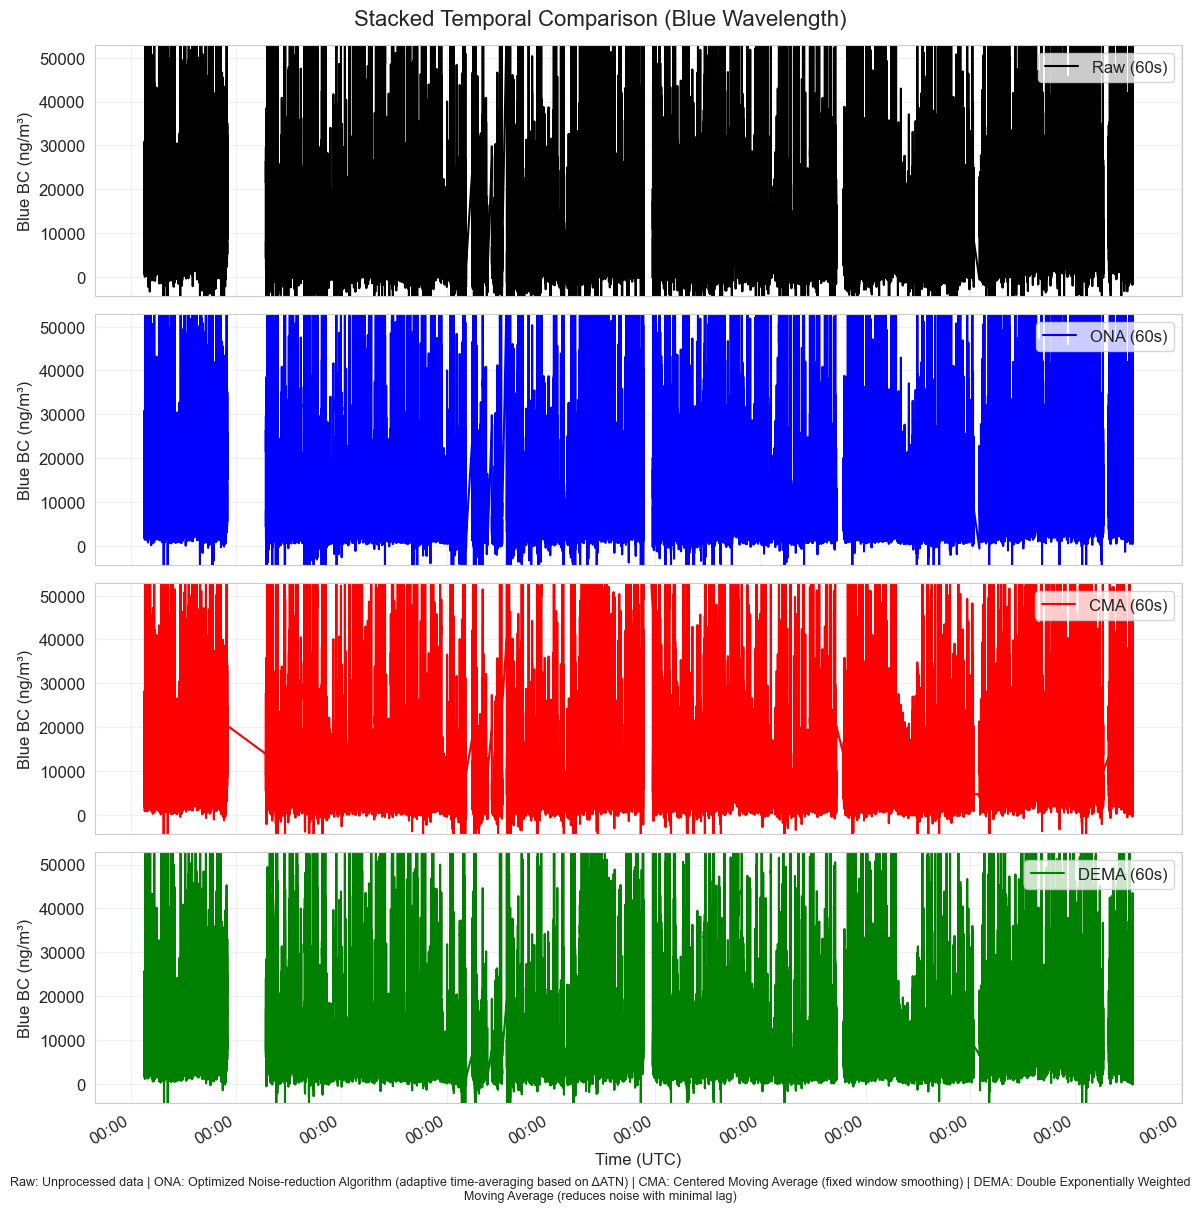


Statistics for Blue wavelength:


shape: (4, 7)
┌────────┬────────────┬─────────────┬─────────────┬──────────────┬──────────────┬───────────────┐
│ Method ┆ Wavelength ┆ Mean        ┆ Median      ┆ Min          ┆ Max          ┆ Std Dev       │
│ ---    ┆ ---        ┆ ---         ┆ ---         ┆ ---          ┆ ---          ┆ ---           │
│ str    ┆ str        ┆ f64         ┆ f64         ┆ f64          ┆ f64          ┆ f64           │
╞════════╪════════════╪═════════════╪═════════════╪══════════════╪══════════════╪═══════════════╡
│ Raw    ┆ Blue       ┆ 8491.342376 ┆ 5588.0      ┆ -2.3433e8    ┆ 2.16328672e8 ┆ 318067.804079 │
│ ONA    ┆ Blue       ┆ 8490.272215 ┆ 5506.0      ┆ -1.1456e8    ┆ 2.16328672e8 ┆ 267699.645548 │
│ CMA    ┆ Blue       ┆ 8490.510609 ┆ 5621.666667 ┆ -7.6084534e7 ┆ 6.1521e7     ┆ 115301.140692 │
│ DEMA   ┆ Blue       ┆ 8491.341611 ┆ 5629.600524 ┆ -5.1429e7    ┆ 1.1565e7     ┆ 70318.902527  │
└────────┴────────────┴─────────────┴─────────────┴──────────────┴──────────────┴───────────────┘


Zoomed view of first 1000 points:


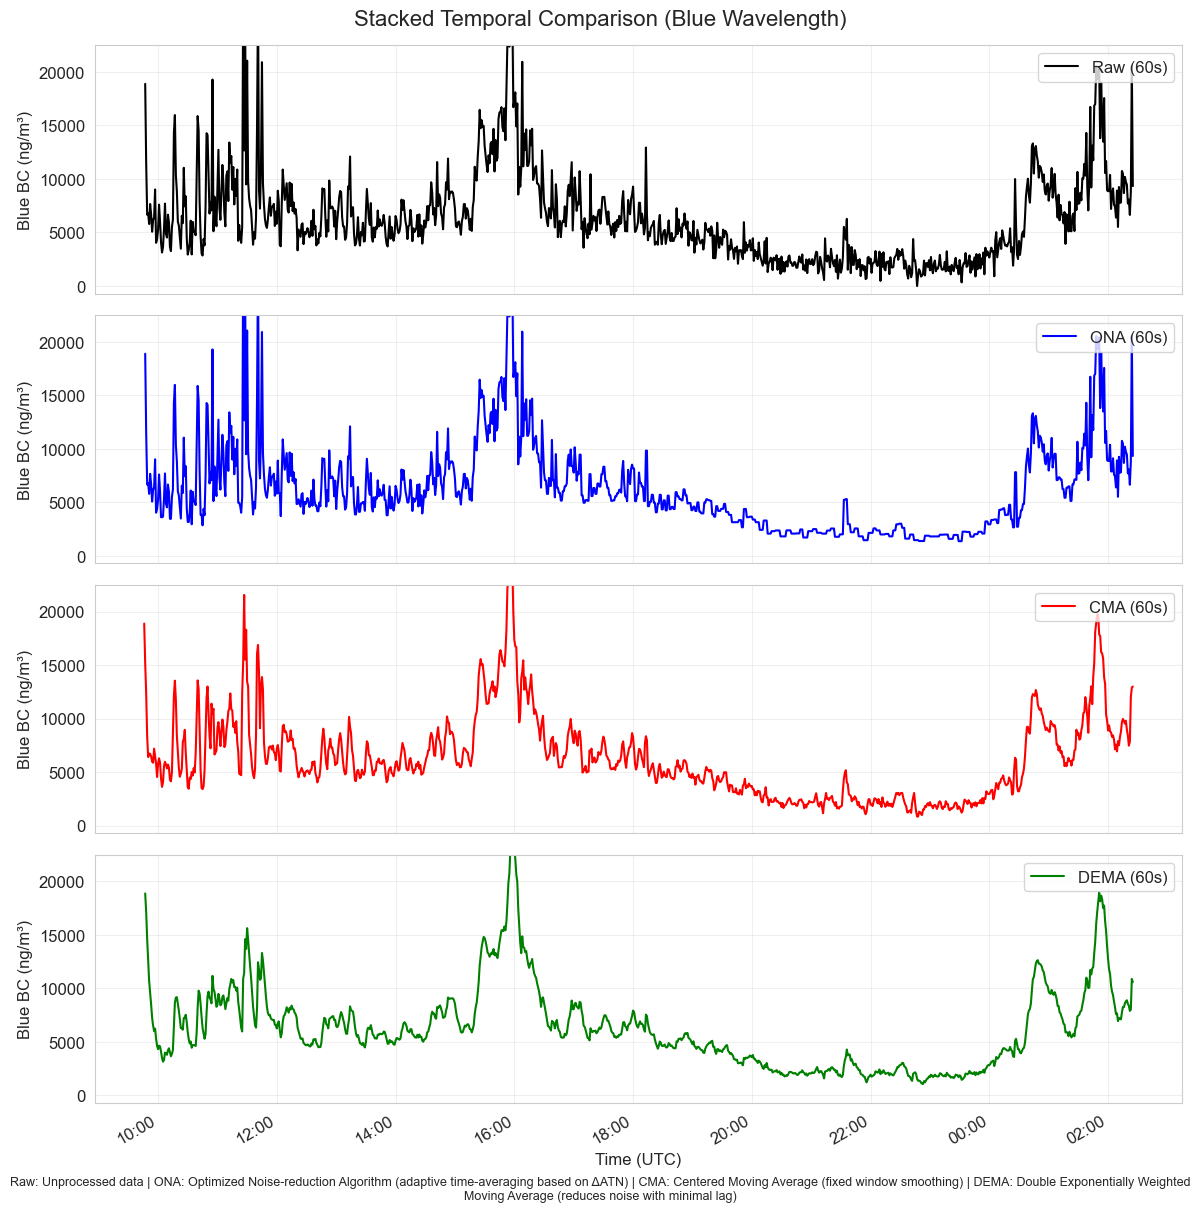


Zoomed Statistics for Blue wavelength:


shape: (4, 7)
┌────────┬────────────┬─────────────┬─────────────┬────────────┬──────────────┬─────────────┐
│ Method ┆ Wavelength ┆ Mean        ┆ Median      ┆ Min        ┆ Max          ┆ Std Dev     │
│ ---    ┆ ---        ┆ ---         ┆ ---         ┆ ---        ┆ ---          ┆ ---         │
│ str    ┆ str        ┆ f64         ┆ f64         ┆ f64        ┆ f64          ┆ f64         │
╞════════╪════════════╪═════════════╪═════════════╪════════════╪══════════════╪═════════════╡
│ Raw    ┆ Blue       ┆ 6286.578579 ┆ 5549.0      ┆ -14.0      ┆ 30867.0      ┆ 4203.535027 │
│ ONA    ┆ Blue       ┆ 6286.578579 ┆ 5505.0      ┆ 1356.0     ┆ 30867.0      ┆ 4167.572964 │
│ CMA    ┆ Blue       ┆ 6297.858167 ┆ 5575.333333 ┆ 837.666667 ┆ 28243.666667 ┆ 3932.702108 │
│ DEMA   ┆ Blue       ┆ 6283.139629 ┆ 5746.332602 ┆ 1061.7537  ┆ 25773.487341 ┆ 3868.1774   │
└────────┴────────────┴─────────────┴─────────────┴────────────┴──────────────┴─────────────┘


Stacked temporal comparison for IR wavelength:


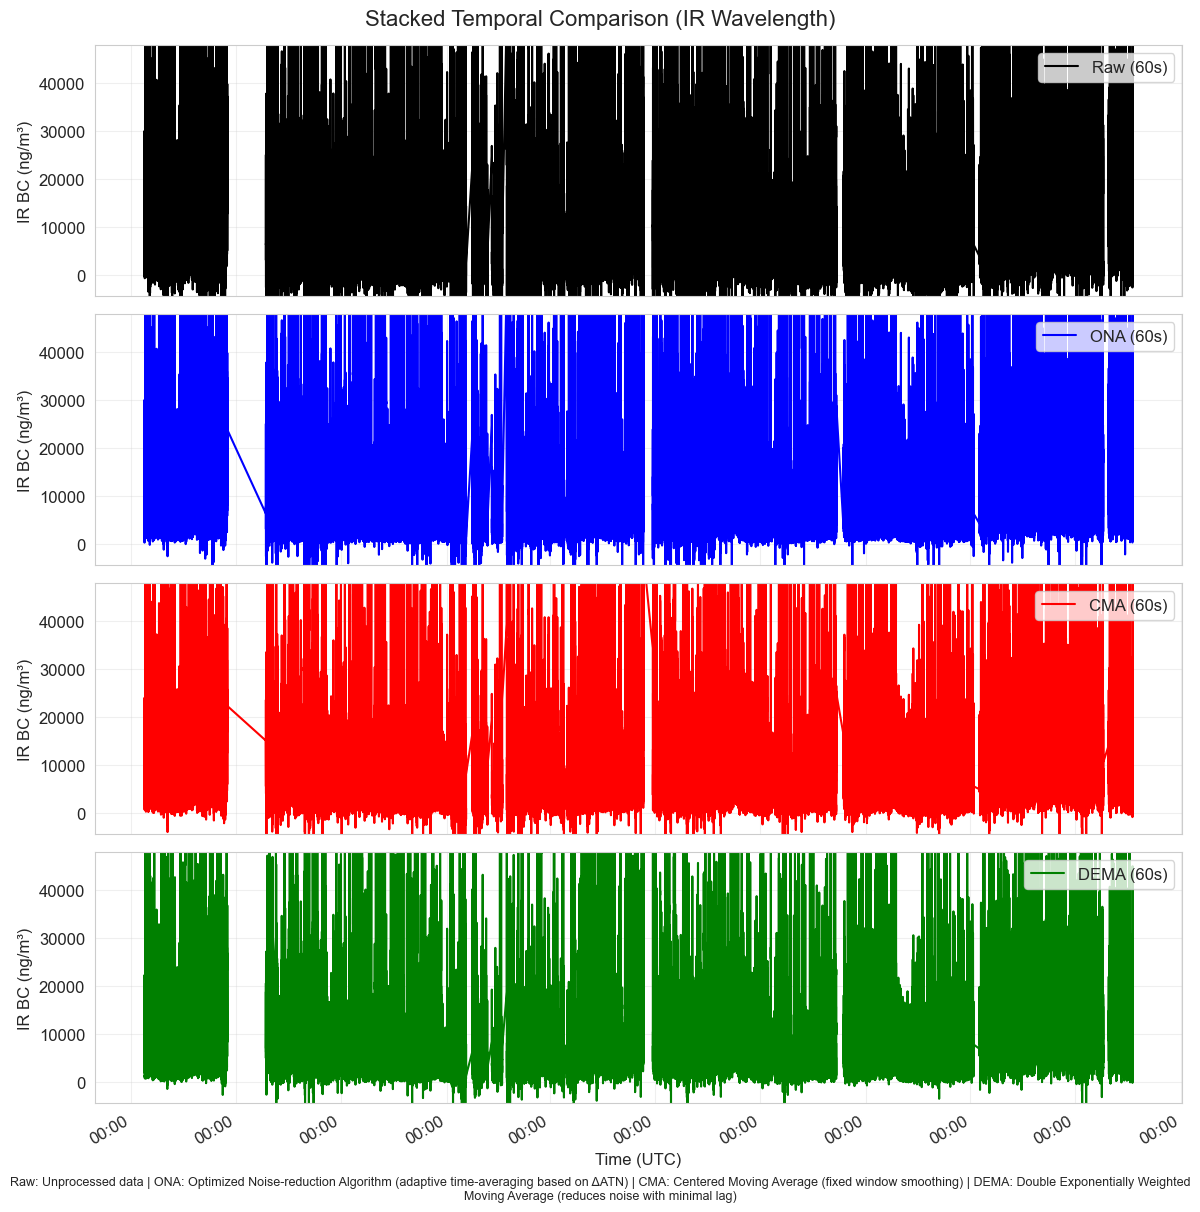


Statistics for IR wavelength:


shape: (4, 7)
┌────────┬────────────┬─────────────┬─────────────┬───────────────┬───────────────┬─────────────┐
│ Method ┆ Wavelength ┆ Mean        ┆ Median      ┆ Min           ┆ Max           ┆ Std Dev     │
│ ---    ┆ ---        ┆ ---         ┆ ---         ┆ ---           ┆ ---           ┆ ---         │
│ str    ┆ str        ┆ f64         ┆ f64         ┆ f64           ┆ f64           ┆ f64         │
╞════════╪════════════╪═════════════╪═════════════╪═══════════════╪═══════════════╪═════════════╡
│ Raw    ┆ IR         ┆ 8137.540267 ┆ 5523.0      ┆ -149717.0     ┆ 547607.0      ┆ 9016.106429 │
│ ONA    ┆ IR         ┆ 8136.480605 ┆ 5414.0      ┆ -96787.0      ┆ 547607.0      ┆ 8800.456887 │
│ CMA    ┆ IR         ┆ 8136.724637 ┆ 5543.333333 ┆ -45458.333333 ┆ 364823.666667 ┆ 8547.660178 │
│ DEMA   ┆ IR         ┆ 8137.537751 ┆ 5556.127436 ┆ -24188.400226 ┆ 214321.506166 ┆ 8455.235615 │
└────────┴────────────┴─────────────┴─────────────┴───────────────┴───────────────┴─────────────┘


Zoomed view of first 1000 points:


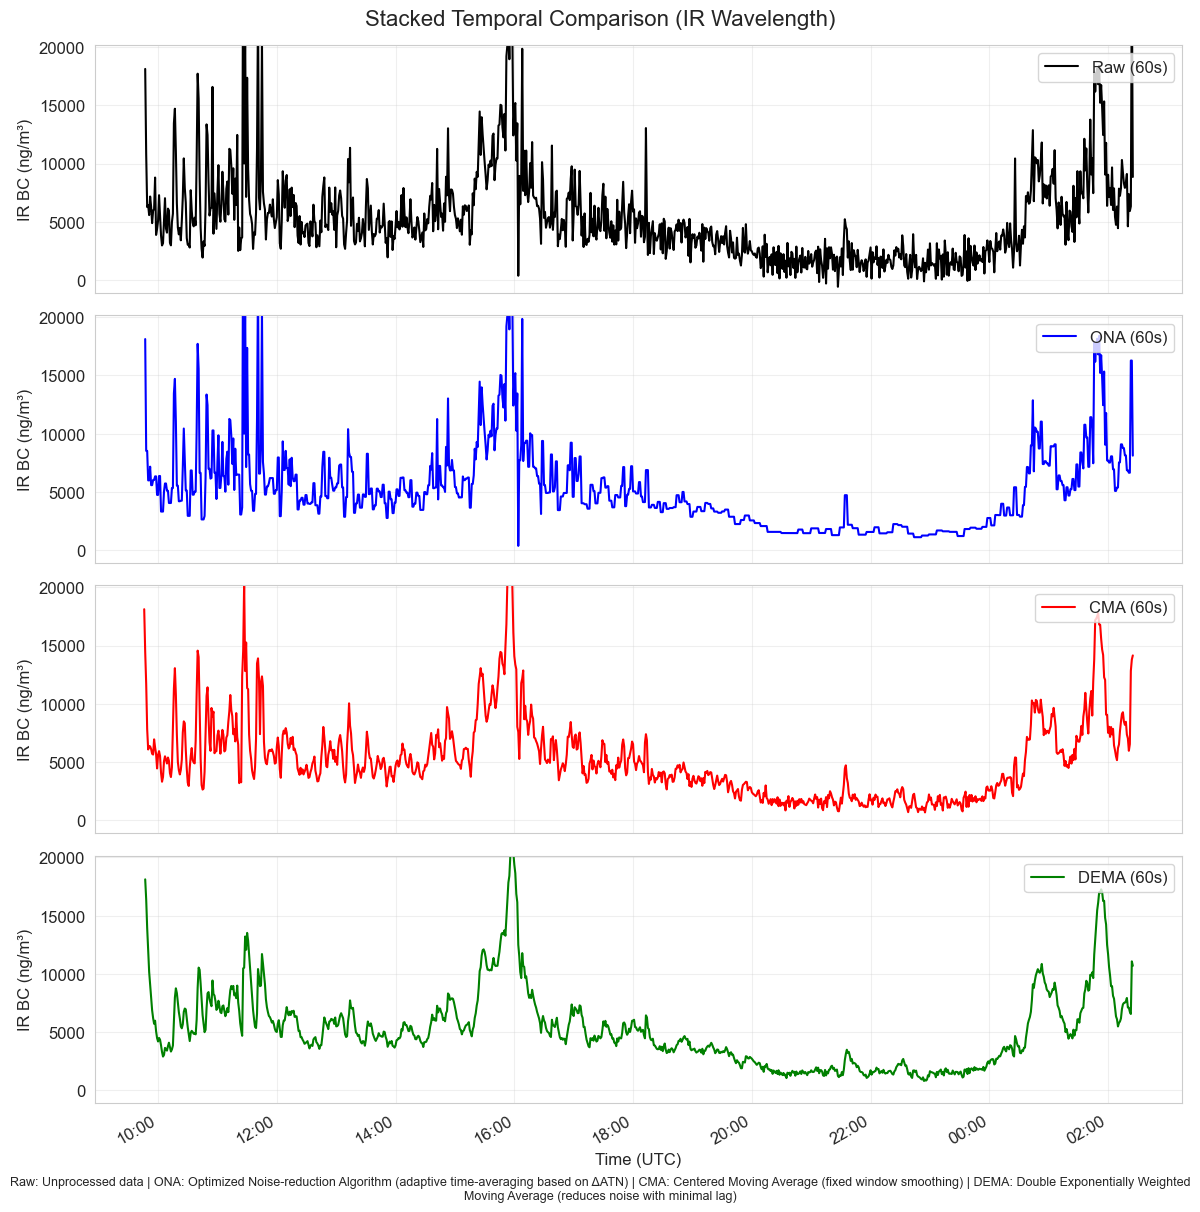


Zoomed Statistics for IR wavelength:


shape: (4, 7)
┌────────┬────────────┬─────────────┬─────────────┬────────────┬──────────────┬─────────────┐
│ Method ┆ Wavelength ┆ Mean        ┆ Median      ┆ Min        ┆ Max          ┆ Std Dev     │
│ ---    ┆ ---        ┆ ---         ┆ ---         ┆ ---        ┆ ---          ┆ ---         │
│ str    ┆ str        ┆ f64         ┆ f64         ┆ f64        ┆ f64          ┆ f64         │
╞════════╪════════════╪═════════════╪═════════════╪════════════╪══════════════╪═════════════╡
│ Raw    ┆ IR         ┆ 5218.687688 ┆ 4464.0      ┆ -577.0     ┆ 29964.0      ┆ 3855.138772 │
│ ONA    ┆ IR         ┆ 5217.954454 ┆ 4608.333333 ┆ 370.0      ┆ 29964.0      ┆ 3700.068118 │
│ CMA    ┆ IR         ┆ 5229.878    ┆ 4613.0      ┆ 676.666667 ┆ 24004.0      ┆ 3480.070072 │
│ DEMA   ┆ IR         ┆ 5211.230327 ┆ 4621.302718 ┆ 815.561464 ┆ 22281.906269 ┆ 3369.841106 │
└────────┴────────────┴─────────────┴─────────────┴────────────┴──────────────┴─────────────┘


Stacked source apportionment comparison:


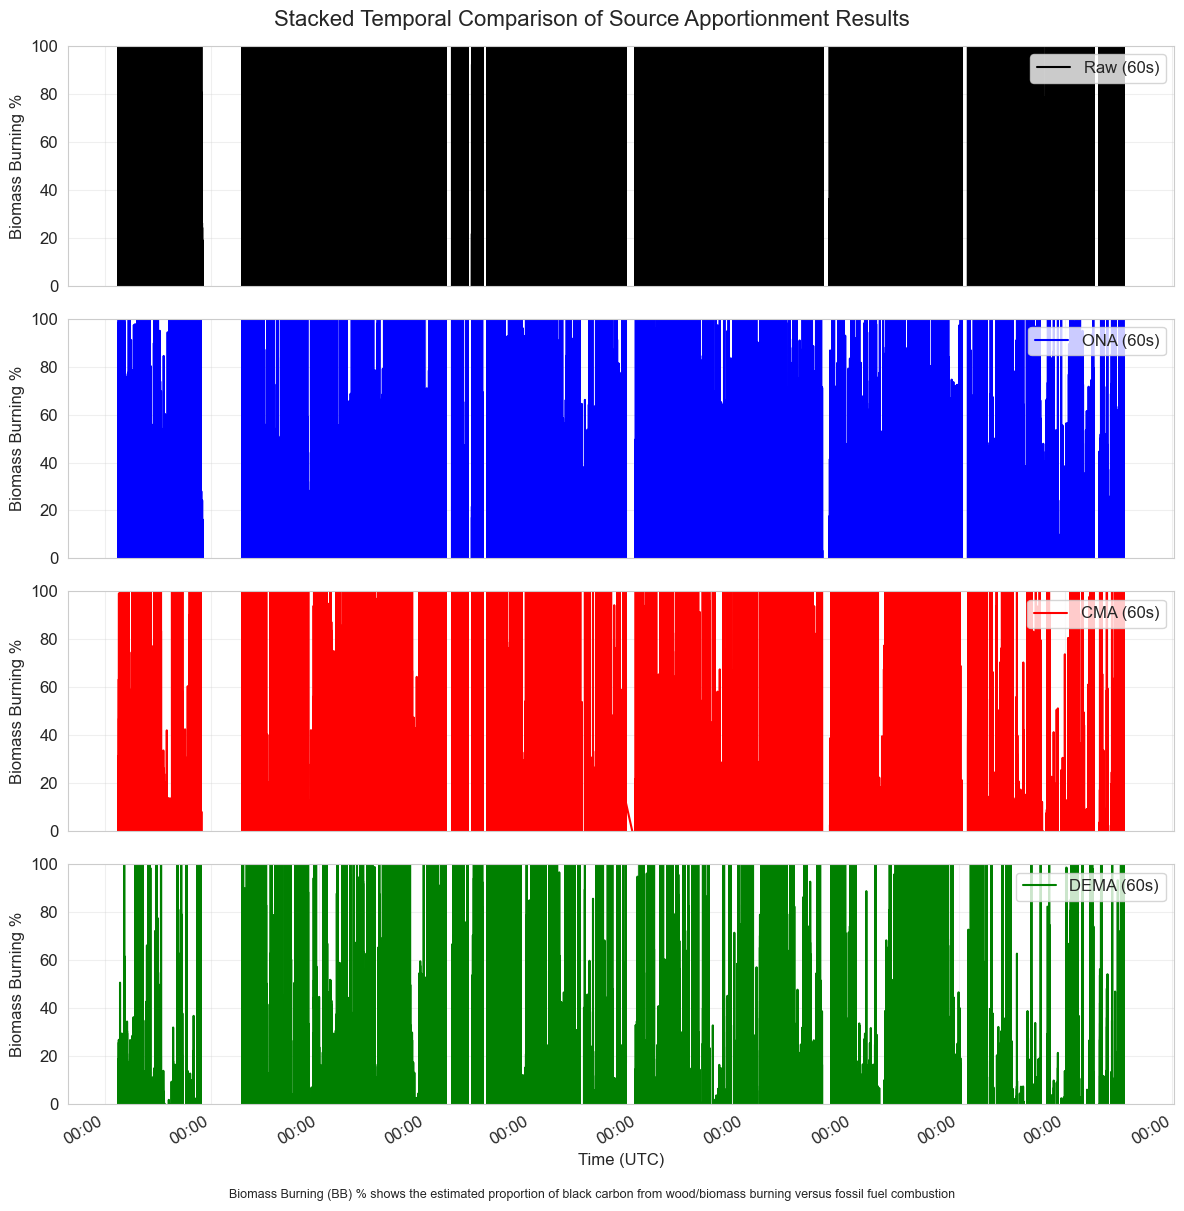


Source Apportionment Statistics:


shape: (4, 6)
┌────────┬────────────┬────────────┬────────────────┬───────────────┬─────────────┐
│ Method ┆ Mean BB%   ┆ Median BB% ┆ Min BB%        ┆ Max BB%       ┆ Std Dev BB% │
│ ---    ┆ ---        ┆ ---        ┆ ---            ┆ ---           ┆ ---         │
│ str    ┆ f64        ┆ f64        ┆ f64            ┆ f64           ┆ f64         │
╞════════╪════════════╪════════════╪════════════════╪═══════════════╪═════════════╡
│ Raw    ┆ -26.472931 ┆ -33.575272 ┆ -1.6076e6      ┆ 1.2859e6      ┆ 3375.762898 │
│ ONA    ┆ -22.764069 ┆ -33.043734 ┆ -539834.232913 ┆ 6.8946e6      ┆ 6697.099625 │
│ CMA    ┆ -28.722768 ┆ -32.992338 ┆ -584375.02559  ┆ 1.1052e6      ┆ 1912.860473 │
│ DEMA   ┆ -29.44112  ┆ -33.214672 ┆ -474158.756644 ┆ 380956.495224 ┆ 1113.763338 │
└────────┴────────────┴────────────┴────────────────┴───────────────┴─────────────┘


Zoomed view of first 1000 points for source apportionment:


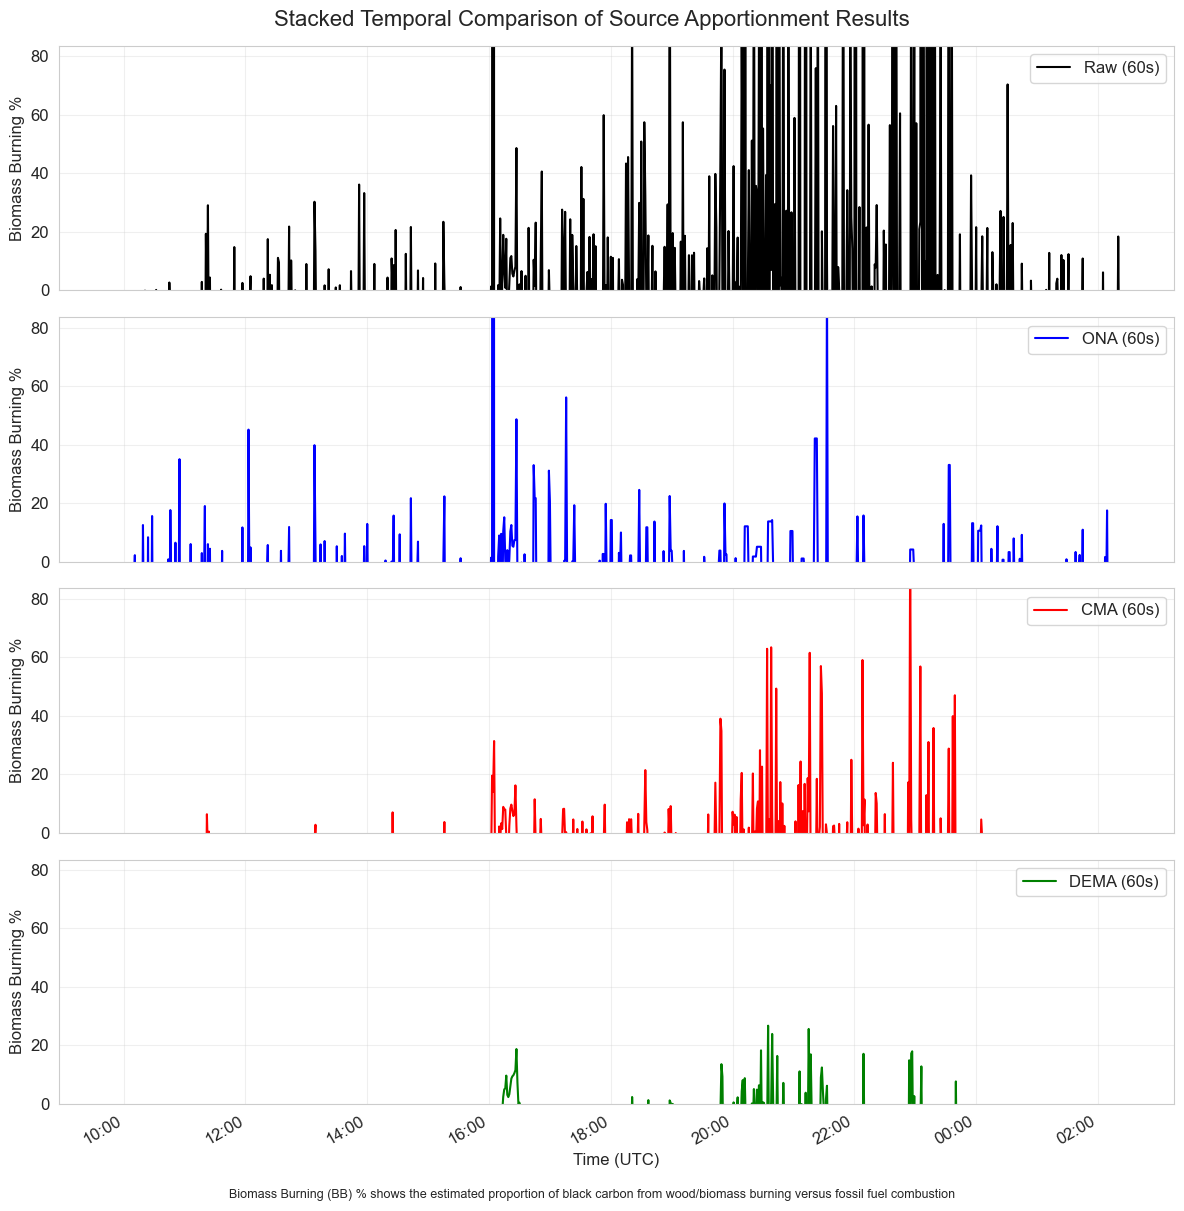


Zoomed Source Apportionment Statistics:


shape: (4, 6)
┌────────┬────────────┬────────────┬───────────────┬─────────────┬─────────────┐
│ Method ┆ Mean BB%   ┆ Median BB% ┆ Min BB%       ┆ Max BB%     ┆ Std Dev BB% │
│ ---    ┆ ---        ┆ ---        ┆ ---           ┆ ---         ┆ ---         │
│ str    ┆ f64        ┆ f64        ┆ f64           ┆ f64         ┆ f64         │
╞════════╪════════════╪════════════╪═══════════════╪═════════════╪═════════════╡
│ Raw    ┆ -42.553042 ┆ -17.353741 ┆ -37965.639158 ┆ 3058.269438 ┆ 1213.215077 │
│ ONA    ┆ -13.672073 ┆ -16.212859 ┆ -80.376483    ┆ 1725.904019 ┆ 57.587043   │
│ CMA    ┆ -15.351622 ┆ -17.533887 ┆ -53.04398     ┆ 99.216595   ┆ 14.588927   │
│ DEMA   ┆ -16.330175 ┆ -17.542572 ┆ -45.222425    ┆ 26.756401   ┆ 9.57253     │
└────────┴────────────┴────────────┴───────────────┴─────────────┴─────────────┘

In [27]:
# Plot stacked temporal comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Use Polars to check if required columns exist
    pl_data = pl.from_pandas(data)
    pl_ona = pl.from_pandas(processed_data_ona)
    pl_cma = pl.from_pandas(processed_data_cma)
    pl_dema = pl.from_pandas(processed_data_dema)
    
    methods_available = []
    if bc_col in pl_data.columns:
        methods_available.append('Raw')
    if ona_col in pl_ona.columns:
        methods_available.append('ONA')
    if cma_col in pl_cma.columns:
        methods_available.append('CMA')
    if dema_col in pl_dema.columns:
        methods_available.append('DEMA')
    
    # Only proceed if at least two methods are available
    if len(methods_available) >= 2:
        print(f"\nStacked temporal comparison for {wavelength} wavelength:")
        
        # Plot full dataset
        tc_stats = plot_stacked_temporal_comparison(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength)
        
        # Display statistics if returned
        if tc_stats is not None:
            print(f"\nStatistics for {wavelength} wavelength:")
            display(tc_stats)
        
        # Calculate sample size using Polars for efficiency
        data_length = pl_data.height
        sample_size = min(1000, int(data_length * 0.1))
        
        if sample_size < data_length:
            print(f"\nZoomed view of first {sample_size} points:")
            tc_zoom_stats = plot_stacked_temporal_comparison(
                data, processed_data_ona, processed_data_cma, processed_data_dema, 
                wavelength, (0, sample_size)
            )
            
            # Display zoom statistics if returned
            if tc_zoom_stats is not None:
                print(f"\nZoomed Statistics for {wavelength} wavelength:")
                display(tc_zoom_stats)

# Plot stacked source apportionment comparisons
# Use Polars to check if source apportionment data is available for at least two methods
pl_raw_sa = pl.from_pandas(processed_data_raw_sa)
pl_ona_sa = pl.from_pandas(processed_data_ona_sa)
pl_cma_sa = pl.from_pandas(processed_data_cma_sa)
pl_dema_sa = pl.from_pandas(processed_data_dema_sa)

sa_methods_available = []
if 'BB_Percent' in pl_raw_sa.columns:
    sa_methods_available.append('Raw')
if 'BB_Percent' in pl_ona_sa.columns:
    sa_methods_available.append('ONA')
if 'BB_Percent' in pl_cma_sa.columns:
    sa_methods_available.append('CMA')
if 'BB_Percent' in pl_dema_sa.columns:
    sa_methods_available.append('DEMA')

if len(sa_methods_available) >= 2:
    print("\nStacked source apportionment comparison:")
    
    # Plot full source apportionment dataset
    sa_stats = plot_stacked_source_apportionment(
        processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa, processed_data_dema_sa
    )
    
    # Display statistics if returned
    if sa_stats is not None:
        print("\nSource Apportionment Statistics:")
        display(sa_stats)

    # Calculate sample size using Polars for efficiency
    # Reuse data_length from previous calculation
    if 'data_length' not in locals():
        pl_data = pl.from_pandas(data)
        data_length = pl_data.height
        
    sample_size = min(1000, int(data_length * 0.1))
    
    if sample_size < data_length:
        print(f"\nZoomed view of first {sample_size} points for source apportionment:")
        
        # Plot zoomed source apportionment
        sa_zoom_stats = plot_stacked_source_apportionment(
            processed_data_raw_sa, processed_data_ona_sa, processed_data_cma_sa,
            processed_data_dema_sa, (0, sample_size)
        )
        
        # Display zoom statistics if returned
        if sa_zoom_stats is not None:
            print("\nZoomed Source Apportionment Statistics:")
            display(sa_zoom_stats)

## 13. Time Averaging Analysis
 
Let's analyze the time averaging behavior of the ONA method and compare it to the effective averaging window of the CMA and DEMA methods.

In [45]:
@numba.jit(nopython=True)
def _numba_nanmean(arr_slice): # Make sure this is defined if used by ONA points calculation
    finite_sum = 0.0
    finite_count = 0
    for x in arr_slice:
        if not np.isnan(x):
            finite_sum += x
            finite_count += 1
    if finite_count == 0:
        return np.nan
    return finite_sum / finite_count

def analyze_time_averaging(data_ona, data_cma, data_dema, wavelength='Blue'):
    """
    Analyze and compare the time averaging behavior of each method.
    Ensure data_ona, data_cma, data_dema are Pandas DataFrames for this version.
    """
    methods = [] # List to store tuples: (method_name, points_series_for_plotting_pd, stats_dict)
    
    # --- Populate 'methods' list ---
    # This section needs your specific logic for calculating ONA points, CMA window, and DEMA equivalent window.
    # Ensure 'points_series_for_plotting_pd' is a Pandas Series (e.g., for ONA's varying points).
    # Ensure 'stats_dict' contains {"mean": float, "median": float, "min": float, "max": float, "std": float}.

    # Example: ONA (ensure data_ona is a Pandas DataFrame)
    points_averaged_col = f"{wavelength}_points_averaged"
    if isinstance(data_ona, pd.DataFrame) and points_averaged_col in data_ona.columns:
        ona_points_pd = data_ona[points_averaged_col].dropna() 
        if not ona_points_pd.empty:
            ona_stats_dict = {
                "mean": float(ona_points_pd.mean()), "median": float(ona_points_pd.median()),
                "min": float(ona_points_pd.min()), "max": float(ona_points_pd.max()), 
                "std": float(ona_points_pd.std()) if ona_points_pd.std() is not None else np.nan
            }
            # Ensure std is nan if it cannot be computed (e.g. single point)
            if pd.isna(ona_stats_dict["std"]) and len(ona_points_pd) <=1 : ona_stats_dict["std"] = 0.0
            elif pd.isna(ona_stats_dict["std"]): ona_stats_dict["std"] = np.nan

            methods.append(('ONA', ona_points_pd, ona_stats_dict))
        else:
            print(f"Warning: ONA points column '{points_averaged_col}' is empty for wavelength {wavelength}.")
    else:
        print(f"Warning: ONA data or points column '{points_averaged_col}' not found/valid for wavelength {wavelength}.")

    # Example: CMA (ensure data_cma is a Pandas DataFrame)
    if isinstance(data_cma, pd.DataFrame) and f"{wavelength}_BC_CMA" in data_cma.columns:
        timebase = data_cma['Timebase (s)'].iloc[0] if 'Timebase (s)' in data_cma.columns and not data_cma.empty else 60
        cma_window = 5 # Default, apply your logic
        if timebase == 1: cma_window = 11
        elif timebase == 5: cma_window = 5
        elif timebase == 60: cma_window = 3
        if cma_window % 2 == 0: cma_window += 1
        
        cma_points_pd = pd.Series([cma_window] * len(data_cma)) # For consistency in plotting if needed
        cma_stats_dict = {"mean": float(cma_window), "median": float(cma_window), 
                          "min": float(cma_window), "max": float(cma_window), "std": 0.0}
        methods.append(('CMA', cma_points_pd, cma_stats_dict))
    else:
        print(f"Warning: CMA data or BC column not found/valid for wavelength {wavelength}.")

    # Example: DEMA (ensure data_dema is a Pandas DataFrame)
    if isinstance(data_dema, pd.DataFrame) and f"{wavelength}_BC_DEMA" in data_dema.columns:
        timebase = data_dema['Timebase (s)'].iloc[0] if 'Timebase (s)' in data_dema.columns and not data_dema.empty else 60
        alpha = 0.125 # Default, apply your logic
        N_dema = 15 # Default N for DEMA if alpha is based on N=(2/alpha)-1
        if timebase == 1: N_dema = 300 / timebase
        elif timebase == 5: N_dema = 300 / timebase
        elif timebase == 60: N_dema = 900 / timebase
        if N_dema > 0 : alpha = 2 / (N_dema + 1)
        
        dema_equiv_window = int(2/alpha - 1) if alpha > 0 else 1
        dema_points_pd = pd.Series([dema_equiv_window] * len(data_dema))
        dema_stats_dict = {"mean": float(dema_equiv_window), "median": float(dema_equiv_window), 
                           "min": float(dema_equiv_window), "max": float(dema_equiv_window), "std": 0.0}
        methods.append(('DEMA', dema_points_pd, dema_stats_dict))
    else:
        print(f"Warning: DEMA data or BC column not found/valid for wavelength {wavelength}.")
    # --- End of Populating 'methods' ---

    if not methods:
        print(f"No time averaging data available for analysis for wavelength {wavelength}")
        return None

    # Create DataFrame for display using Pandas (transposed view)
    display_data_for_pd = {"Metric": ["Mean", "Median", "Min", "Max", "Std Dev"]}
    for name, _, stats_dict_item in methods:
        display_data_for_pd[name] = [
            stats_dict_item["mean"], stats_dict_item["median"],
            stats_dict_item["min"], stats_dict_item["max"], stats_dict_item["std"]
        ]
    df_for_display_pd = pd.DataFrame(display_data_for_pd).set_index("Metric")
    
    print(f"\nSummary statistics of window sizes for {wavelength} wavelength:")
    display(df_for_display_pd.style.format("{:.2f}", na_rep="N/A"))


    # Plotting logic (histograms, ECDF)
    plt.figure(figsize=(12, 6))
    has_ona_for_hist = any(name == 'ONA' for name, _, _ in methods)
    
    for name, points_series_for_plotting_pd, stats in methods:
        if name == 'ONA' and not points_series_for_plotting_pd.empty:
            plt.hist(points_series_for_plotting_pd, bins=30, alpha=0.7, label=f'ONA (adaptive, mean={stats["mean"]:.1f})')
        elif name == 'CMA':
            plt.axvline(stats["mean"], color='red', linestyle='dashed', linewidth=2, label=f'CMA (fixed, window={int(stats["mean"])})')
        elif name == 'DEMA':
            plt.axvline(stats["mean"], color='green', linestyle='dashed', linewidth=2, label=f'DEMA (equiv. window={int(stats["mean"])})')
    
    plt.xlabel('Number of Points Averaged')
    plt.ylabel('Frequency' if has_ona_for_hist else 'Density (Conceptual for fixed windows)')
    plt.title(f'Averaging Window Size Comparison - {wavelength} Wavelength')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # ECDF plot for ONA
    ona_points_data_for_ecdf = None
    for name, points_pd, _ in methods:
        if name == 'ONA': 
            ona_points_data_for_ecdf = points_pd.sort_values()
            break
            
    if ona_points_data_for_ecdf is not None and not ona_points_data_for_ecdf.empty:
        plt.figure(figsize=(10, 6))
        y_ecdf = np.arange(1, len(ona_points_data_for_ecdf) + 1) / len(ona_points_data_for_ecdf)
        plt.plot(ona_points_data_for_ecdf, y_ecdf, marker='.', linestyle='none')
        plt.xlabel('Number of Points Averaged (ONA)')
        plt.ylabel('ECDF')
        plt.title(f'ECDF of ONA Adaptive Window Size - {wavelength} Wavelength')
        plt.grid(True, alpha=0.3)
        if ona_points_data_for_ecdf.min() > 0 and (ona_points_data_for_ecdf.max() / ona_points_data_for_ecdf.min() > 100 if ona_points_data_for_ecdf.min() != 0 else False) :
             plt.xscale('log')
        plt.tight_layout()
        plt.show()

    # Create Polars DataFrame for returning (with 'Method' as a column)
    # Ensure all stats are float or can be handled by Polars as nulls if np.nan
    df_for_return = pl.DataFrame({
        "Method": [m[0] for m in methods],
        "Mean": [m[2]["mean"] for m in methods],
        "Median": [m[2]["median"] for m in methods],
        "Min": [m[2]["min"] for m in methods],
        "Max": [m[2]["max"] for m in methods],
        "Std Dev": [m[2]["std"] for m in methods]
    }, schema={ # Define schema to handle potential NaNs correctly as Float64
        "Method": pl.Utf8, "Mean": pl.Float64, "Median": pl.Float64,
        "Min": pl.Float64, "Max": pl.Float64, "Std Dev": pl.Float64
    })
    
    return df_for_return


Time averaging analysis for Blue wavelength:

Summary statistics of window sizes for Blue wavelength:


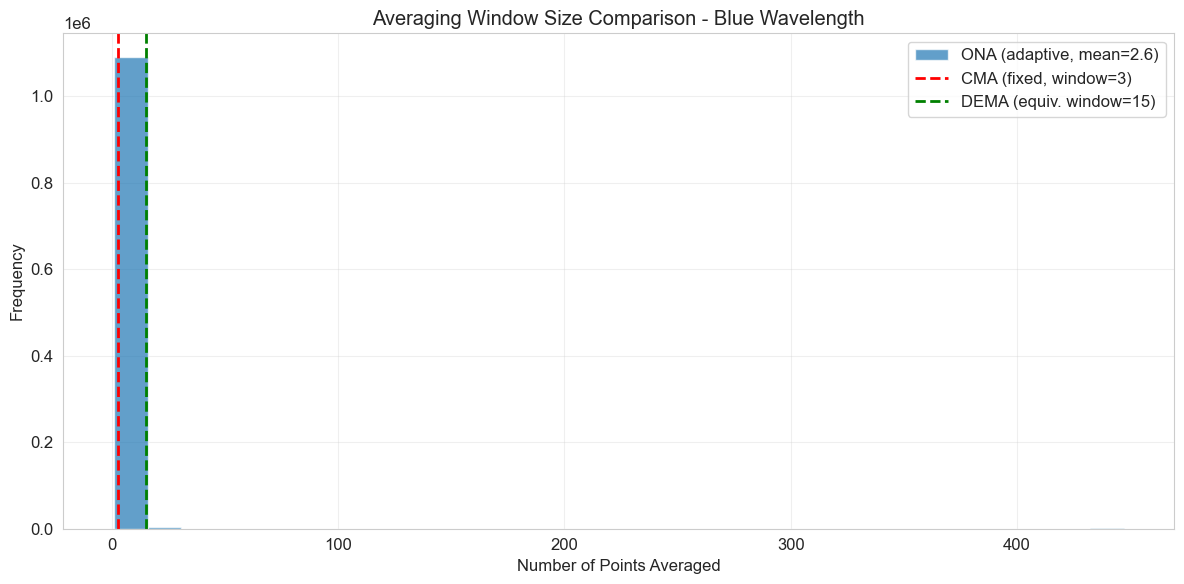

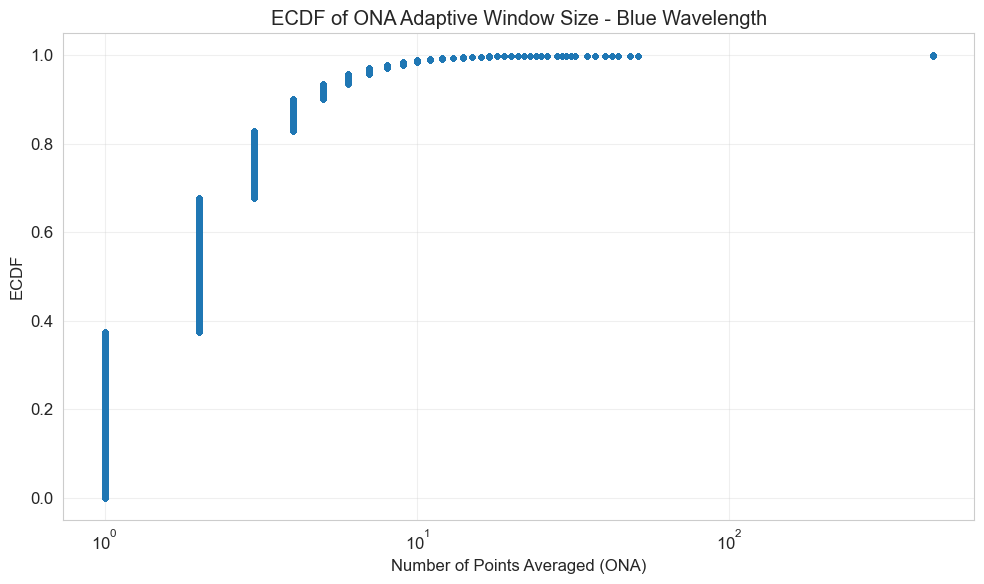


Time averaging analysis for IR wavelength:

Summary statistics of window sizes for IR wavelength:


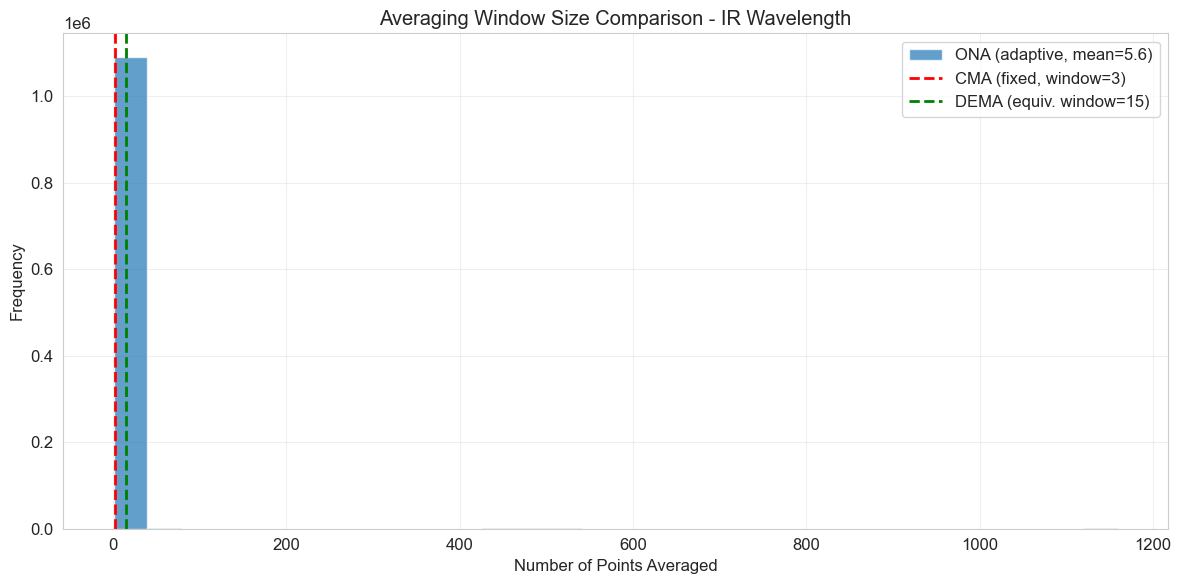

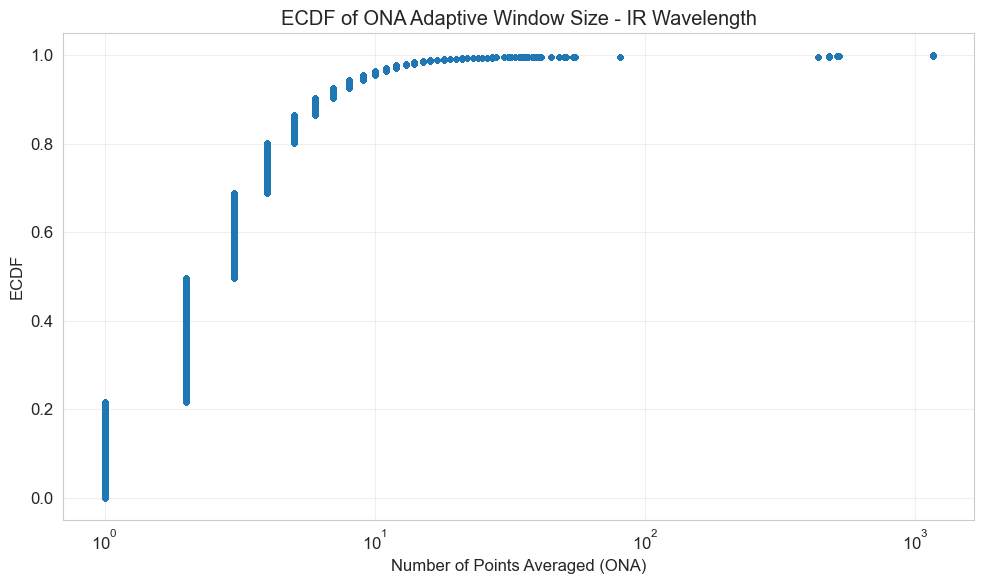

In [46]:
# Analyze time averaging for each wavelength
for wavelength in ['Blue', 'IR']:
    print(f"\nTime averaging analysis for {wavelength} wavelength:")
    analyze_time_averaging(processed_data_ona, processed_data_cma, processed_data_dema, wavelength)


## 14. Comparing Signal Preservation

Let's examine how well each method preserves important signal features by looking at cross-correlation and lag.

In [49]:
def analyze_signal_preservation(data_raw, data_ona, data_cma, data_dema, wavelength='Blue'):
    """
    Analyze how well each method preserves important signal features
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw data
    data_ona : pandas.DataFrame
        DataFrame with ONA processed data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to analyze
    """
    # Identify columns
    bc_col = f"{wavelength} BCc"
    ona_col = f"{wavelength}_BC_ONA"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Check which methods are available
    methods = []
    if bc_col in data_raw.columns:
        # Convert to Polars for standardization
        pl_raw = pl.from_pandas(data_raw[[bc_col]])
        raw_mean = pl_raw.select(pl.col(bc_col).mean())[0, 0]
        raw_std = pl_raw.select(pl.col(bc_col).std())[0, 0]
        
        # Standardize the raw data using Polars
        pl_raw_std = pl_raw.with_columns(
            ((pl.col(bc_col) - raw_mean) / raw_std).alias("std_value")
        )
        
        # Convert back to numpy for correlation calculation
        raw_std_values = pl_raw_std["std_value"].fill_null(0).to_numpy()
        
        # Process each method
        if ona_col in data_ona.columns:
            pl_ona = pl.from_pandas(data_ona[[ona_col]])
            ona_mean = pl_ona.select(pl.col(ona_col).mean())[0, 0]
            ona_std = pl_ona.select(pl.col(ona_col).std())[0, 0]
            
            pl_ona_std = pl_ona.with_columns(
                ((pl.col(ona_col) - ona_mean) / ona_std).alias("std_value")
            )
            
            ona_std_values = pl_ona_std["std_value"].fill_null(0).to_numpy()
            methods.append(('ONA', ona_std_values))
            
        if cma_col in data_cma.columns:
            pl_cma = pl.from_pandas(data_cma[[cma_col]])
            cma_mean = pl_cma.select(pl.col(cma_col).mean())[0, 0]
            cma_std = pl_cma.select(pl.col(cma_col).std())[0, 0]
            
            pl_cma_std = pl_cma.with_columns(
                ((pl.col(cma_col) - cma_mean) / cma_std).alias("std_value")
            )
            
            cma_std_values = pl_cma_std["std_value"].fill_null(0).to_numpy()
            methods.append(('CMA', cma_std_values))
            
        if dema_col in data_dema.columns:
            pl_dema = pl.from_pandas(data_dema[[dema_col]])
            dema_mean = pl_dema.select(pl.col(dema_col).mean())[0, 0]
            dema_std = pl_dema.select(pl.col(dema_col).std())[0, 0]
            
            pl_dema_std = pl_dema.with_columns(
                ((pl.col(dema_col) - dema_mean) / dema_std).alias("std_value")
            )
            
            dema_std_values = pl_dema_std["std_value"].fill_null(0).to_numpy()
            methods.append(('DEMA', dema_std_values))
    else:
        print(f"Raw data for {wavelength} wavelength not available")
        return
    
    if len(methods) == 0:
        print("No processed data available for analysis")
        return
    
    # Calculate cross-correlation and find peak for each method
    results = {}
    lags = {}
    peak_corrs = {}
    
    max_lag = 20  # Maximum lag to consider (in data points)
    
    for name, processed_std in methods:
        # Calculate cross-correlation
        xcorr = np.correlate(raw_std_values, processed_std, mode='full')
        
        # Calculate the midpoint
        mid = len(xcorr) // 2
        
        # Extract the central portion of the cross-correlation
        lag_range = max_lag * 2 + 1
        central_xcorr = xcorr[mid - max_lag:mid + max_lag + 1]
        lags_array = np.arange(-max_lag, max_lag + 1)
        
        # Find the peak correlation and its lag
        peak_idx = np.argmax(central_xcorr)
        peak_lag = lags_array[peak_idx]
        peak_corr = central_xcorr[peak_idx]
        
        # Store results
        results[name] = {
            'xcorr': central_xcorr,
            'lags': lags_array
        }
        lags[name] = peak_lag
        peak_corrs[name] = peak_corr
    
    # Plot cross-correlation for each method
    plt.figure(figsize=(10, 6))
    
    for name, result in results.items():
        if name == 'ONA':
            plt.plot(result['lags'], result['xcorr'], 'b-', label=f'ONA (lag={lags[name]})')
        elif name == 'CMA':
            plt.plot(result['lags'], result['xcorr'], 'r-', label=f'CMA (lag={lags[name]})')
        elif name == 'DEMA':
            plt.plot(result['lags'], result['xcorr'], 'g-', label=f'DEMA (lag={lags[name]})')
    
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Lag (data points)')
    plt.ylabel('Cross-Correlation')
    plt.title(f'Cross-Correlation with Raw Data - {wavelength} Wavelength')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Create the summary Polars DataFrame
    summary = pl.DataFrame({
        'Method': list(results.keys()), # Ensure 'results' is correctly populated
        'Lag (data points)': [lags[name] for name in results.keys()], # Ensure 'lags' is correctly populated
        'Peak Correlation': [peak_corrs[name] for name in results.keys()] # Ensure 'peak_corrs' is correctly populated
    })
    
    print(f"\nSignal preservation metrics for {wavelength} wavelength:")
    display(summary) # You are already displaying it

    return summary   # <<<< ADD THIS LINE or ensure it's the last executed statement



Signal preservation analysis for Blue wavelength:


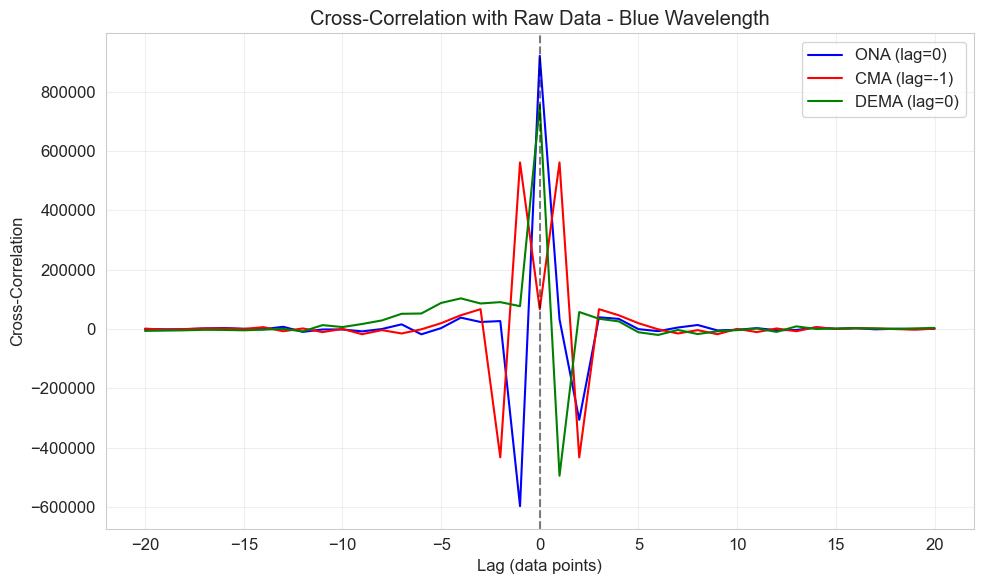


Signal preservation metrics for Blue wavelength:


shape: (3, 3)
┌────────┬───────────────────┬──────────────────┐
│ Method ┆ Lag (data points) ┆ Peak Correlation │
│ ---    ┆ ---               ┆ ---              │
│ str    ┆ i64               ┆ f64              │
╞════════╪═══════════════════╪══════════════════╡
│ ONA    ┆ 0                 ┆ 921584.199775    │
│ CMA    ┆ -1                ┆ 561966.789436    │
│ DEMA   ┆ 0                 ┆ 756040.88783     │
└────────┴───────────────────┴──────────────────┘


Signal preservation analysis for IR wavelength:


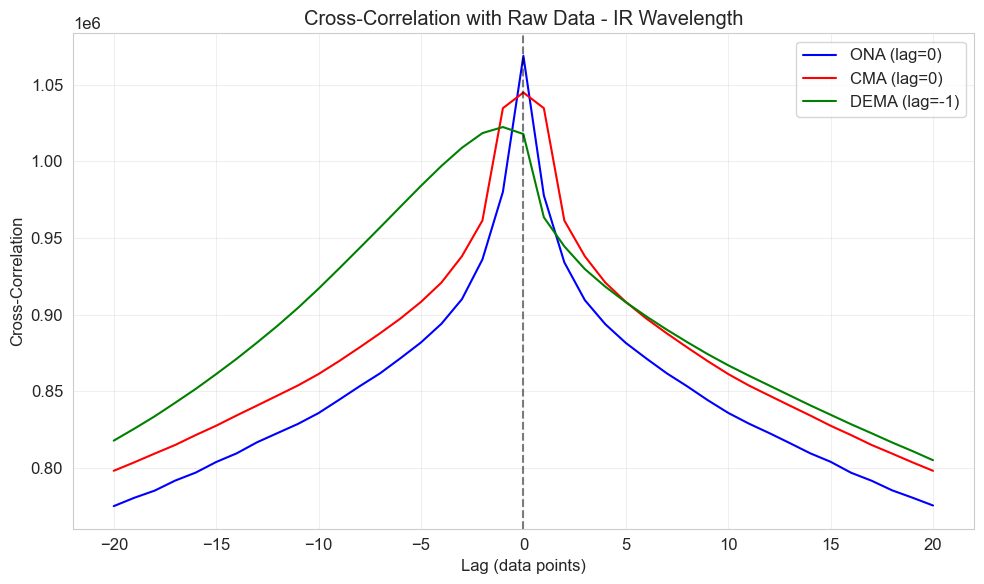


Signal preservation metrics for IR wavelength:


shape: (3, 3)
┌────────┬───────────────────┬──────────────────┐
│ Method ┆ Lag (data points) ┆ Peak Correlation │
│ ---    ┆ ---               ┆ ---              │
│ str    ┆ i64               ┆ f64              │
╞════════╪═══════════════════╪══════════════════╡
│ ONA    ┆ 0                 ┆ 1.0688e6         │
│ CMA    ┆ 0                 ┆ 1.0448e6         │
│ DEMA   ┆ -1                ┆ 1.0223e6         │
└────────┴───────────────────┴──────────────────┘

In [ ]:
# Analyze signal preservation for each wavelength
for wavelength in ['Blue', 'IR']:
    print(f"\nSignal preservation analysis for {wavelength} wavelength:")
    analyze_signal_preservation(data, processed_data_ona, processed_data_cma, processed_data_dema, wavelength)


## 15. Comparative Analysis Summary
 
Now let's summarize the performance of all three methods across key metrics.

In [51]:
def create_method_comparison_table(
    wavelength: str,
    summary_metrics_all_wavelengths_pd: pd.DataFrame, # Pandas DF from evaluate_processing
    signal_preservation_pl: pl.DataFrame = None,      # Polars DF from analyze_signal_preservation
    time_averaging_pl: pl.DataFrame = None,           # Polars DF from analyze_time_averaging
    sa_stability_by_method: dict = None               # Dict {'ONA': std_dev, ...}
):
    """
    Create a quantitative comparison table for processing methods for a specific wavelength.
    """
    methods_to_compare = ['ONA', 'CMA', 'DEMA'] # Define the methods you are comparing
    
    # Define the metrics to be included in the table
    table_metrics = [
        'Negative Value Reduction (%)',
        'Noise Reduction Factor (x)',
        'Correlation with Raw Data',
        'Signal Lag (data points)',
        'Peak Cross-Correlation Value (Standardized)', # Renamed for clarity
        'Mean Points Averaged (Window Size)',
        'Std Dev of BB% (SA Stability)'
    ]
    
    # Initialize data structure for Polars DataFrame
    table_data_dict = {'Metric': table_metrics}
    for method in methods_to_compare:
        table_data_dict[method] = ['N/A'] * len(table_metrics)
        
    comparison_pl = pl.DataFrame(table_data_dict)

    # Ensure summary_metrics_all_wavelengths_pd is a Pandas DataFrame before reset_index
    if not isinstance(summary_metrics_all_wavelengths_pd, pd.DataFrame):
        print(f"Warning: summary_metrics_all_wavelengths_pd is not a Pandas DataFrame for wavelength {wavelength}. Skipping some metrics.")
        summary_pl = None
    else:
        summary_pl = pl.from_pandas(summary_metrics_all_wavelengths_pd.reset_index())

    for method_name in methods_to_compare:
        # --- Populate metrics from summary_pl (derived from evaluate_processing) ---
        if summary_pl is not None:
            summary_key_for_method = f"{wavelength}_{method_name}" # e.g., "Blue_ONA"
            filtered_summary_rows = summary_pl.filter(pl.col('index') == summary_key_for_method)
            
            if filtered_summary_rows.height > 0:
                row_data = filtered_summary_rows.row(0, named=True) # Get row as dict

                # Negative Value Reduction
                if 'Negative reduction' in row_data and row_data['Negative reduction'] is not None:
                    val = row_data['Negative reduction']
                    comparison_pl = comparison_pl.with_columns(
                        pl.when(pl.col('Metric') == 'Negative Value Reduction (%)')
                        .then(pl.lit(f"{val * 100:.1f}")) # Assuming val is fraction 0-1
                        .otherwise(pl.col(method_name))
                        .alias(method_name)
                    )
                # Noise Reduction Factor
                if 'Noise reduction factor' in row_data and row_data['Noise reduction factor'] is not None:
                    val = row_data['Noise reduction factor']
                    comparison_pl = comparison_pl.with_columns(
                        pl.when(pl.col('Metric') == 'Noise Reduction Factor (x)')
                        .then(pl.lit(f"{val:.1f}x"))
                        .otherwise(pl.col(method_name))
                        .alias(method_name)
                    )
                # Correlation with Raw Data
                if 'Correlation with raw' in row_data and row_data['Correlation with raw'] is not None:
                    val = row_data['Correlation with raw']
                    comparison_pl = comparison_pl.with_columns(
                        pl.when(pl.col('Metric') == 'Correlation with Raw Data')
                        .then(pl.lit(f"{val:.3f}"))
                        .otherwise(pl.col(method_name))
                        .alias(method_name)
                    )

        # --- Populate metrics from signal_preservation_pl ---
        if signal_preservation_pl is not None:
            signal_row_data = signal_preservation_pl.filter(pl.col('Method') == method_name)
            if signal_row_data.height > 0:
                row_data = signal_row_data.row(0, named=True)
                # Signal Lag
                if 'Lag (data points)' in row_data and row_data['Lag (data points)'] is not None:
                    val = row_data['Lag (data points)']
                    comparison_pl = comparison_pl.with_columns(
                        pl.when(pl.col('Metric') == 'Signal Lag (data points)')
                        .then(pl.lit(str(val)))
                        .otherwise(pl.col(method_name))
                        .alias(method_name)
                    )
                # Peak Cross-Correlation Value
                if 'Peak Correlation' in row_data and row_data['Peak Correlation'] is not None:
                    val = row_data['Peak Correlation']
                    # Note: This value from analyze_signal_preservation is not a normalized correlation coefficient (-1 to 1).
                    # It's the max value of the cross-correlation of standardized series.
                    comparison_pl = comparison_pl.with_columns(
                        pl.when(pl.col('Metric') == 'Peak Cross-Correlation Value (Standardized)')
                        .then(pl.lit(f"{val:.3e}")) # Use scientific notation if values can be large/small
                        .otherwise(pl.col(method_name))
                        .alias(method_name)
                    )
        
        # --- Populate metrics from time_averaging_pl ---
        if time_averaging_pl is not None:
            time_avg_row_data = time_averaging_pl.filter(pl.col('Method') == method_name)
            if time_avg_row_data.height > 0:
                row_data = time_avg_row_data.row(0, named=True)
                # Mean Points Averaged (Window Size)
                if 'Mean' in row_data and row_data['Mean'] is not None: # 'Mean' column from analyze_time_averaging
                    val = row_data['Mean']
                    comparison_pl = comparison_pl.with_columns(
                        pl.when(pl.col('Metric') == 'Mean Points Averaged (Window Size)')
                        .then(pl.lit(f"{val:.1f}"))
                        .otherwise(pl.col(method_name))
                        .alias(method_name)
                    )

        # --- Populate metrics from sa_stability_by_method ---
        # This metric is global per method, not per wavelength of BC processing, but shown in each table for completeness.
        if sa_stability_by_method and method_name in sa_stability_by_method:
            val = sa_stability_by_method[method_name]
            if val is not None and not np.isnan(val):
                comparison_pl = comparison_pl.with_columns(
                    pl.when(pl.col('Metric') == 'Std Dev of BB% (SA Stability)')
                    .then(pl.lit(f"{val:.2f}"))
                    .otherwise(pl.col(method_name))
                    .alias(method_name)
                )
            
    comparison_pl = comparison_pl.sort("Metric")
    return comparison_pl

## 16. Conclusions and Method Recommendations
 
This notebook implemented and compared three post-processing algorithms for aethalometer data: ONA, CMA, and DEMA.


===== Quantitative Method Comparison Tables (Wavelength Specific) =====
DEBUG: Running analyze_signal_preservation for Blue in fallback.


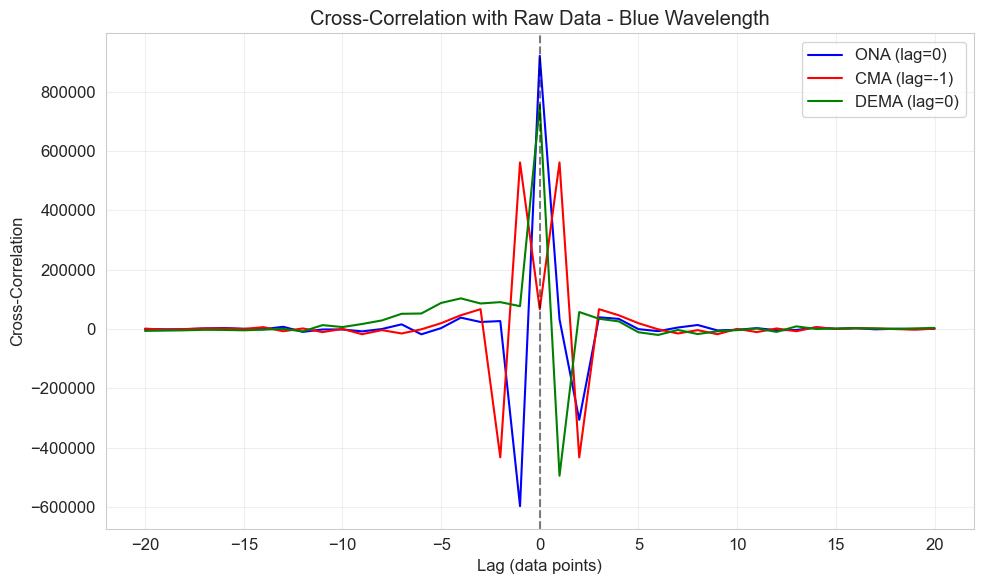


Signal preservation metrics for Blue wavelength:


shape: (3, 3)
┌────────┬───────────────────┬──────────────────┐
│ Method ┆ Lag (data points) ┆ Peak Correlation │
│ ---    ┆ ---               ┆ ---              │
│ str    ┆ i64               ┆ f64              │
╞════════╪═══════════════════╪══════════════════╡
│ ONA    ┆ 0                 ┆ 921584.199775    │
│ CMA    ┆ -1                ┆ 561966.789436    │
│ DEMA   ┆ 0                 ┆ 756040.88783     │
└────────┴───────────────────┴──────────────────┘

DEBUG: Storing signal_pres_df for Blue. Is None: False. Shape: (3, 3)
DEBUG: Running analyze_signal_preservation for IR in fallback.


In [ ]:
print("\n===== Quantitative Method Comparison Tables (Wavelength Specific) =====")

# Ensure summary_table (pandas DataFrame from evaluate_processing in Section 9) is available
# Ensure sa_stability_metrics (dict from Step 2 of previous instructions) is available

# Initialize stores if not run interactively section by section
if 'time_averaging_results_store' not in locals() or not isinstance(time_averaging_results_store, dict):
    print("DEBUG: Initializing `time_averaging_results_store` dictionary.")
    time_averaging_results_store = {}

if 'signal_preservation_results_store' not in locals() or not isinstance(signal_preservation_results_store, dict):
    print("DEBUG: Initializing `signal_preservation_results_store` dictionary.")
    signal_preservation_results_store = {}

# Fallback logic if stores are empty (e.g., first run or non-sequential execution)
if not time_averaging_results_store: # Check if dict is empty
    print("Warning: `time_averaging_results_store` is empty or not found. Running analysis now to populate.")
    for wl_ana in ['Blue', 'IR']:
        print(f"DEBUG: Running analyze_time_averaging for {wl_ana} in fallback.")
        if 'processed_data_ona' in locals() and 'processed_data_cma' in locals() and 'processed_data_dema' in locals():
            df_time_avg = analyze_time_averaging(processed_data_ona, processed_data_cma, processed_data_dema, wl_ana)
            if df_time_avg is not None:
                print(f"DEBUG: Storing time_avg_df for {wl_ana}. Is None: {df_time_avg is None}. Shape: {df_time_avg.shape if df_time_avg is not None else 'N/A'}")
                time_averaging_results_store[wl_ana] = df_time_avg
            else:
                print(f"DEBUG: analyze_time_averaging for {wl_ana} returned None.")
        else:
            print(f"DEBUG: Skipped analyze_time_averaging for {wl_ana} in fallback due to missing processed dataframes.")

if not signal_preservation_results_store: # Check if dict is empty
    print("Warning: `signal_preservation_results_store` is empty or not found. Running analysis now to populate.")
    for wl_ana in ['Blue', 'IR']:
        print(f"DEBUG: Running analyze_signal_preservation for {wl_ana} in fallback.")
        if 'data' in locals() and 'processed_data_ona' in locals() and 'processed_data_cma' in locals() and 'processed_data_dema' in locals():
            df_signal = analyze_signal_preservation(data, processed_data_ona, processed_data_cma, processed_data_dema, wl_ana)
            if df_signal is not None:
                print(f"DEBUG: Storing signal_pres_df for {wl_ana}. Is None: {df_signal is None}. Shape: {df_signal.shape if df_signal is not None else 'N/A'}")
                signal_preservation_results_store[wl_ana] = df_signal
            else:
                print(f"DEBUG: analyze_signal_preservation for {wl_ana} returned None.")
        else:
             print(f"DEBUG: Skipped analyze_signal_preservation for {wl_ana} in fallback due to missing dataframes.")


if 'summary_table' not in locals() or not isinstance(summary_table, pd.DataFrame):
    print("Error: `summary_table` (Pandas DataFrame from Section 9) is not available. Cannot generate comparison tables.")
elif 'sa_stability_metrics' not in locals() or not isinstance(sa_stability_metrics, dict):
    print("Error: `sa_stability_metrics` (dict) is not available. Cannot generate comparison tables.") # This was your error
else:
    all_comparison_tables = {}
    for wl_to_compare in ['Blue', 'IR']:
        print(f"\n----- Comparison Table for {wl_to_compare} Wavelength -----")
        
        current_signal_metrics_pl = signal_preservation_results_store.get(wl_to_compare)
        current_time_avg_metrics_pl = time_averaging_results_store.get(wl_to_compare)
        
        print(f"DEBUG: For table [{wl_to_compare}]: current_time_avg_metrics_pl is None? {current_time_avg_metrics_pl is None}")
        if current_time_avg_metrics_pl is not None:
            print("DEBUG: current_time_avg_metrics_pl head:")
            display(current_time_avg_metrics_pl.head())
        
        print(f"DEBUG: For table [{wl_to_compare}]: current_signal_metrics_pl is None? {current_signal_metrics_pl is None}")
        if current_signal_metrics_pl is not None:
            print("DEBUG: current_signal_metrics_pl head:")
            display(current_signal_metrics_pl.head())
        
        comparison_table_for_wl = create_method_comparison_table(
            wavelength=wl_to_compare,
            summary_metrics_all_wavelengths_pd=summary_table, 
            signal_preservation_pl=current_signal_metrics_pl,
            time_averaging_pl=current_time_avg_metrics_pl,
            sa_stability_by_method=sa_stability_metrics
        )
        display(comparison_table_for_wl)
        all_comparison_tables[wl_to_compare] = comparison_table_for_wl

## 17. Save Processed Data

In [35]:
def save_processed_data(data, processed_data_ona, processed_data_cma, processed_data_dema, output_file):
    """
    Save processed data with all methods to a CSV file using Polars for better performance
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Original data
    processed_data_ona : pandas.DataFrame
        ONA processed data
    processed_data_cma : pandas.DataFrame
        CMA processed data
    processed_data_dema : pandas.DataFrame
        DEMA processed data
    output_file : str
        Output file path
    
    Returns:
    --------
    pl_combined : polars.DataFrame
        Combined DataFrame with all processed data
    """
    # Start with base data as Polars DataFrame
    pl_combined = pl.from_pandas(data)
    
    # Convert processing results to Polars DataFrames
    pl_ona = pl.from_pandas(processed_data_ona)
    pl_cma = pl.from_pandas(processed_data_cma)
    pl_dema = pl.from_pandas(processed_data_dema)
    
    # Add ONA columns - only those not already in the combined data
    ona_cols = [col for col in pl_ona.columns if col not in pl_combined.columns]
    for col in ona_cols:
        pl_combined = pl_combined.with_columns(
            pl_ona.select(pl.col(col)).to_series()
        )
    
    # Add CMA columns - only those not already in the combined data
    cma_cols = [col for col in pl_cma.columns if col not in pl_combined.columns]
    for col in cma_cols:
        pl_combined = pl_combined.with_columns(
            pl_cma.select(pl.col(col)).to_series()
        )
    
    # Add DEMA columns - only those not already in the combined data
    dema_cols = [col for col in pl_dema.columns if col not in pl_combined.columns]
    for col in dema_cols:
        pl_combined = pl_combined.with_columns(
            pl_dema.select(pl.col(col)).to_series()
        )
    
    # Save to CSV directly using Polars - more efficient for large datasets
    pl_combined.write_csv(output_file)
    print(f"Processed data from all methods saved to {output_file}")
    
    # Return the combined DataFrame in case it's needed for further processing
    return pl_combined

# Save the processed data
output_file = "aethalometer_data_all_methods.csv"
combined_data = save_processed_data(data, processed_data_ona, processed_data_cma, processed_data_dema, output_file)

# Optional: Print summary of what was saved
print("\nSummary of saved data:")
print(f"Total columns: {len(combined_data.columns)}")
print(f"Total rows: {combined_data.height}")

# Count columns by processing method
ona_cols = [col for col in combined_data.columns if '_BC_ONA' in col or '_points_averaged' in col]
cma_cols = [col for col in combined_data.columns if '_BC_CMA' in col]
dema_cols = [col for col in combined_data.columns if '_BC_DEMA' in col or '_EMA' in col]
sa_cols = [col for col in combined_data.columns if 'BB_Percent' in col or 'BC_WB' in col or 'BC_FF' in col]

print(f"Original data columns: {len(combined_data.columns) - len(ona_cols) - len(cma_cols) - len(dema_cols) - len(sa_cols)}")
print(f"ONA-related columns: {len(ona_cols)}")
print(f"CMA-related columns: {len(cma_cols)}")
print(f"DEMA-related columns: {len(dema_cols)}")
print(f"Source apportionment columns: {len(sa_cols)}")

Processed data from all methods saved to aethalometer_data_all_methods.csv

Summary of saved data:
Total columns: 102
Total rows: 1095086
Original data columns: 77
ONA-related columns: 10
CMA-related columns: 5
DEMA-related columns: 10
Source apportionment columns: 0
